In [25]:
# LSTM 기반 경제지표 예측 모델
# 필요한 라이브러리 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# LSTM 모델링을 위한 라이브러리
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow version:", tf.__version__)
except ImportError:
    print("TensorFlow가 설치되지 않았습니다. pip install tensorflow를 실행하세요.")

# 데이터 전처리를 위한 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 시계열 검정을 위한 라이브러리
from statsmodels.tsa.stattools import adfuller

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료")

TensorFlow version: 2.20.0
라이브러리 import 완료


In [2]:
# 데이터 로드 및 탐색
# 목표 변수 정의
target_variables = [
    'construction_bsi_actual',
    'base_rate',
    'housing_sale_price',
    'm2_growth',
    'credit_spread'
]

# 데이터 로드
df = pd.read_csv('ecos_monthly_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(f"전체 데이터 형태: {df.shape}")
print(f"시작 날짜: {df.index[0]}")
print(f"종료 날짜: {df.index[-1]}")
print(f"총 관측치: {len(df)}개월")

# 목표 변수들 확인
print(f"\n목표 변수들:")
for var in target_variables:
    print(f"- {var}")

# 목표 변수들 추출
df_target = df[target_variables].copy()
print(f"\n목표 변수 데이터 형태: {df_target.shape}")
print(f"\n기본 통계:")
print(df_target.describe().round(4))

전체 데이터 형태: (187, 27)
시작 날짜: 2010-02-01 00:00:00
종료 날짜: 2025-08-01 00:00:00
총 관측치: 187개월

목표 변수들:
- construction_bsi_actual
- base_rate
- housing_sale_price
- m2_growth
- credit_spread

목표 변수 데이터 형태: (187, 5)

기본 통계:
       construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
count                 187.0000   187.0000            187.0000   187.0000   
mean                   75.1176     2.0909             80.3713     0.5501   
std                     7.9133     0.9248             10.6294     0.3525   
min                    51.0000     0.5000             65.0400    -0.4100   
25%                    70.0000     1.3750             70.9490     0.3100   
50%                    74.0000     2.0000             77.3320     0.5100   
75%                    80.0000     2.8750             92.9790     0.7650   
max                    95.0000     3.5000            100.8690     1.5600   

       credit_spread  
count       187.0000  
mean          6.0040  
std           0.2508  
min    

결측치 확인:
construction_bsi_actual    0
base_rate                  0
housing_sale_price         0
m2_growth                  0
credit_spread              0
dtype: int64


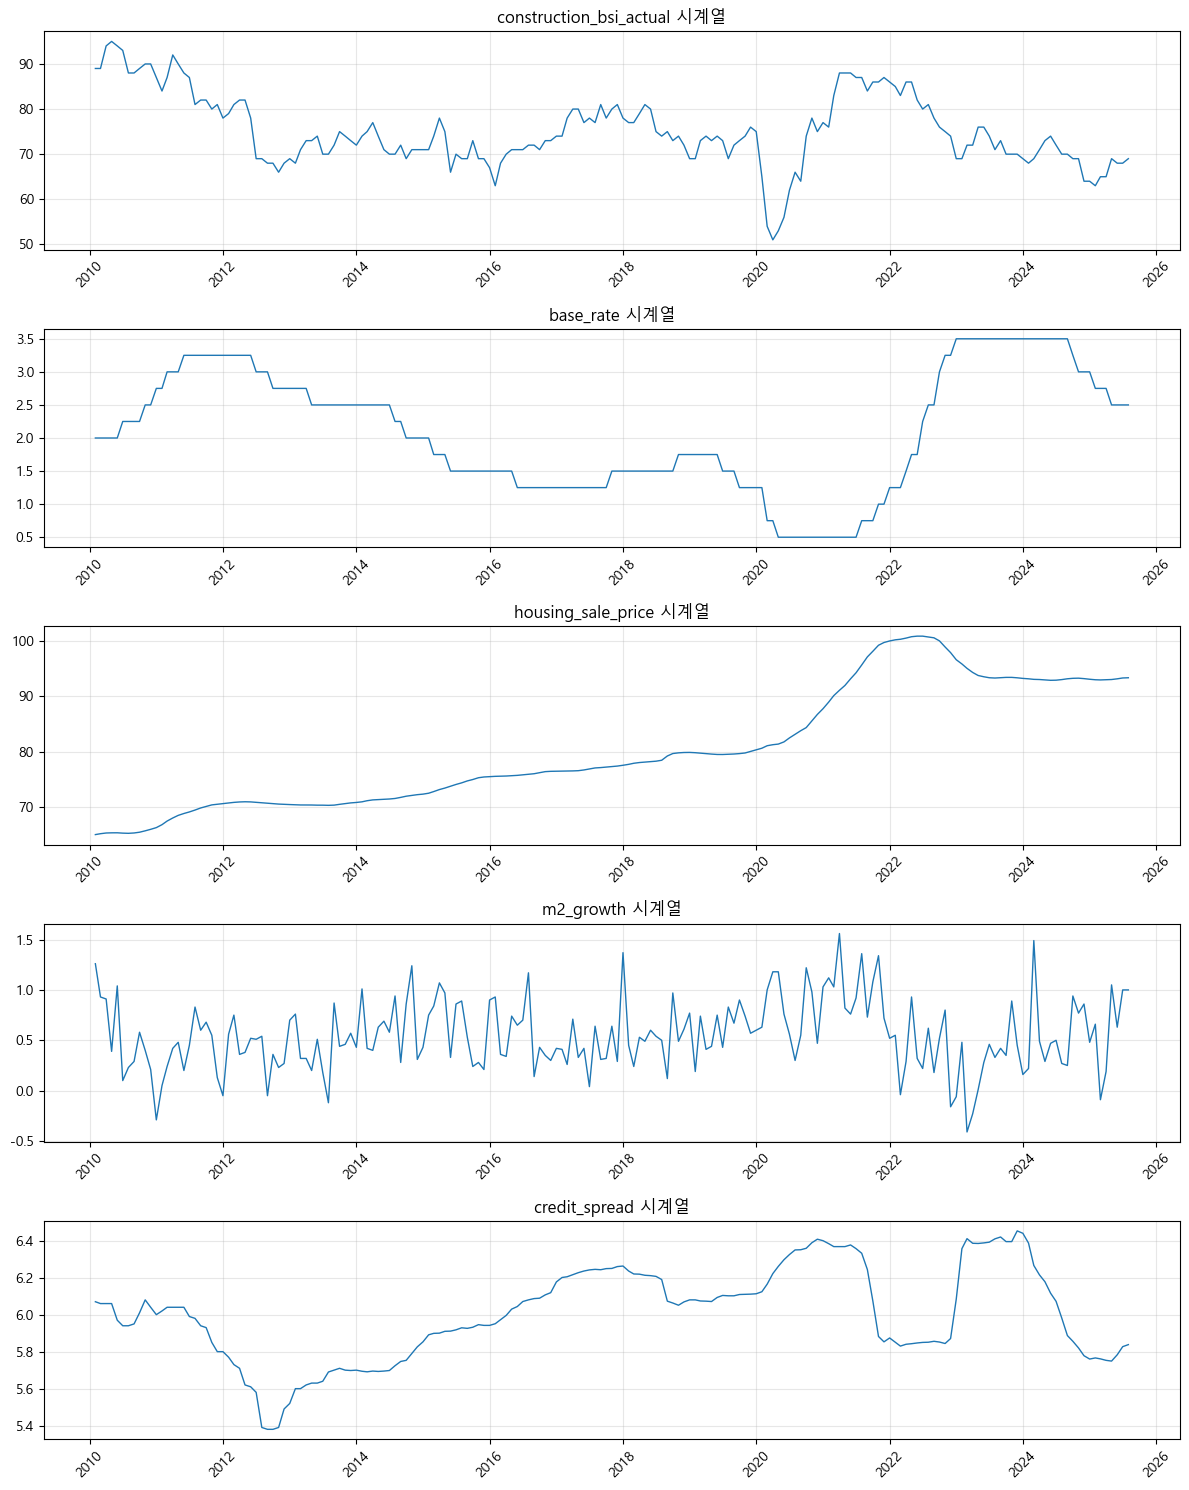


전처리된 데이터 형태: (187, 5)


In [3]:
# 데이터 전처리
# 결측치 확인 및 처리
print("결측치 확인:")
missing_info = df_target.isnull().sum()
print(missing_info)

if missing_info.sum() > 0:
    print("\n결측치를 선형 보간법으로 처리")
    df_target = df_target.interpolate(method='linear')
    print("처리 후 결측치:", df_target.isnull().sum().sum())

# 각 변수의 시각화
fig, axes = plt.subplots(len(target_variables), 1, figsize=(12, 3*len(target_variables)))

for i, var in enumerate(target_variables):
    ax = axes[i] if len(target_variables) > 1 else axes
    ax.plot(df_target.index, df_target[var], linewidth=1)
    ax.set_title(f'{var} 시계열')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n전처리된 데이터 형태: {df_target.shape}")

In [4]:
# 정상성 검정 (ADF Test)
def check_stationarity(data, var_name):
    """ADF 테스트를 통한 정상성 검정"""
    result = adfuller(data.dropna())
    print(f"{var_name}:")
    print(f"  ADF 통계량: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  정상성: {'정상' if result[1] < 0.05 else '비정상'}")
    return result[1] < 0.05

print("정상성 검정 결과:")
print("=" * 40)

stationarity_results = {}
for var in target_variables:
    is_stationary = check_stationarity(df_target[var], var)
    stationarity_results[var] = is_stationary
    print()

# 차분 필요한 변수들 처리
df_stationary = df_target.copy()
diff_applied = {}

print("차분 처리:")
print("=" * 40)

for var in target_variables:
    if not stationarity_results[var]:
        # 1차 차분 적용
        df_stationary[var] = df_target[var].diff()
        diff_applied[var] = 1
        
        # 1차 차분 후 정상성 재검정
        is_stationary_diff = check_stationarity(df_stationary[var], f"{var}_diff1")
        
        if not is_stationary_diff:
            # 2차 차분 적용
            df_stationary[var] = df_target[var].diff().diff()
            diff_applied[var] = 2
            print(f"{var}: 2차 차분 적용")
        else:
            print(f"{var}: 1차 차분 적용")
    else:
        diff_applied[var] = 0
        print(f"{var}: 차분 불필요")

# 차분 적용 후 결측치 제거
df_stationary = df_stationary.dropna()
print(f"\n차분 후 데이터 형태: {df_stationary.shape}")
print(f"사용 가능한 관측치: {len(df_stationary)}개월")

정상성 검정 결과:
construction_bsi_actual:
  ADF 통계량: -3.1967
  p-value: 0.0202
  정상성: 정상

base_rate:
  ADF 통계량: -1.9548
  p-value: 0.3067
  정상성: 비정상

housing_sale_price:
  ADF 통계량: -1.4584
  p-value: 0.5540
  정상성: 비정상

m2_growth:
  ADF 통계량: -2.4830
  p-value: 0.1197
  정상성: 비정상

credit_spread:
  ADF 통계량: -2.7240
  p-value: 0.0700
  정상성: 비정상

차분 처리:
construction_bsi_actual: 차분 불필요
base_rate_diff1:
  ADF 통계량: -3.9901
  p-value: 0.0015
  정상성: 정상
base_rate: 1차 차분 적용
housing_sale_price_diff1:
  ADF 통계량: -2.5876
  p-value: 0.0956
  정상성: 비정상
housing_sale_price: 2차 차분 적용
m2_growth_diff1:
  ADF 통계량: -7.7150
  p-value: 0.0000
  정상성: 정상
m2_growth: 1차 차분 적용
credit_spread_diff1:
  ADF 통계량: -7.1537
  p-value: 0.0000
  정상성: 정상
credit_spread: 1차 차분 적용

차분 후 데이터 형태: (185, 5)
사용 가능한 관측치: 185개월


In [26]:
# LSTM 입력 데이터 생성
def create_lstm_sequences(data, lookback_window):
    """시계열 데이터를 LSTM 입력 형태로 변환"""
    X, y = [], []
    
    for i in range(lookback_window, len(data)):
        # lookback_window 길이만큼의 과거 데이터를 입력으로 사용
        X.append(data[i-lookback_window:i])
        # 다음 시점의 모든 변수를 예측 대상으로 설정
        y.append(data[i])
    
    return np.array(X), np.array(y)

# 데이터 정규화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_stationary)

# 룩백 윈도우 설정 (과거 12개월 데이터로 다음 월 예측)
lookback_window = 12

# LSTM 시퀀스 생성
X, y = create_lstm_sequences(scaled_data, lookback_window)

print(f"LSTM 입력 데이터 형태:")
print(f"X (입력): {X.shape} - (샘플수, 시간스텝, 특성수)")
print(f"y (출력): {y.shape} - (샘플수, 특성수)")

# 훈련/검증/테스트 분할
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"\n데이터 분할:")
print(f"훈련 데이터: {X_train.shape[0]}개")
print(f"검증 데이터: {X_val.shape[0]}개")
print(f"테스트 데이터: {X_test.shape[0]}개")

# 전체 데이터에서 마지막 lookback_window 데이터 저장 (예측용)
last_sequence = scaled_data[-lookback_window:]
print(f"\n예측용 마지막 시퀀스 형태: {last_sequence.shape}")

LSTM 입력 데이터 형태:
X (입력): (173, 12, 5) - (샘플수, 시간스텝, 특성수)
y (출력): (173, 5) - (샘플수, 특성수)

데이터 분할:
훈련 데이터: 121개
검증 데이터: 25개
테스트 데이터: 27개

예측용 마지막 시퀀스 형태: (12, 5)


In [6]:
# LSTM 모델 구성
def build_lstm_model(input_shape, output_dim):
    """다변량 LSTM 모델 구성"""
    model = Sequential([
        # 첫 번째 LSTM 레이어 (상태 반환)
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        # 두 번째 LSTM 레이어
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        
        # 완전연결 레이어
        Dense(25, activation='relu'),
        Dropout(0.2),
        
        # 출력 레이어 (5개 변수 동시 예측)
        Dense(output_dim, activation='linear')
    ])
    
    return model

# 모델 생성
input_shape = (lookback_window, len(target_variables))
output_dim = len(target_variables)

model = build_lstm_model(input_shape, output_dim)

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# 모델 구조 출력
print("LSTM 모델 구조:")
print("=" * 40)
model.summary()

# 학습 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

print(f"\n모델 설정 완료:")
print(f"입력 형태: {input_shape}")
print(f"출력 차원: {output_dim}")
print(f"예측 변수: {target_variables}")

LSTM 모델 구조:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,805 (128.14 KB)

 Trainable params: 32,805 (128.14 KB)

 Non-trainable params: 0 (0.00 B)


모델 설정 완료:
입력 형태: (12, 5)
출력 차원: 5
예측 변수: ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']


LSTM 모델 훈련 시작...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1726 - mae: 0.3756 - val_loss: 0.1634 - val_mae: 0.3340
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0768 - mae: 0.2270 - val_loss: 0.0603 - val_mae: 0.1987
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0528 - mae: 0.1834 - val_loss: 0.0515 - val_mae: 0.1782
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0478 - mae: 0.1698 - val_loss: 0.0598 - val_mae: 0.1908
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0371 - mae: 0.1514 - val_loss: 0.0460 - val_mae: 0.1602
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0332 - mae: 0.1427 - val_loss: 0.0501 - val_mae: 0.1734
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0312 - mae: 0.1363 - val_loss: 0.0465 - val_mae: 0.1642
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0283 - mae: 0.1291 - val_loss: 0.0477 - val_mae: 0.1640
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - los

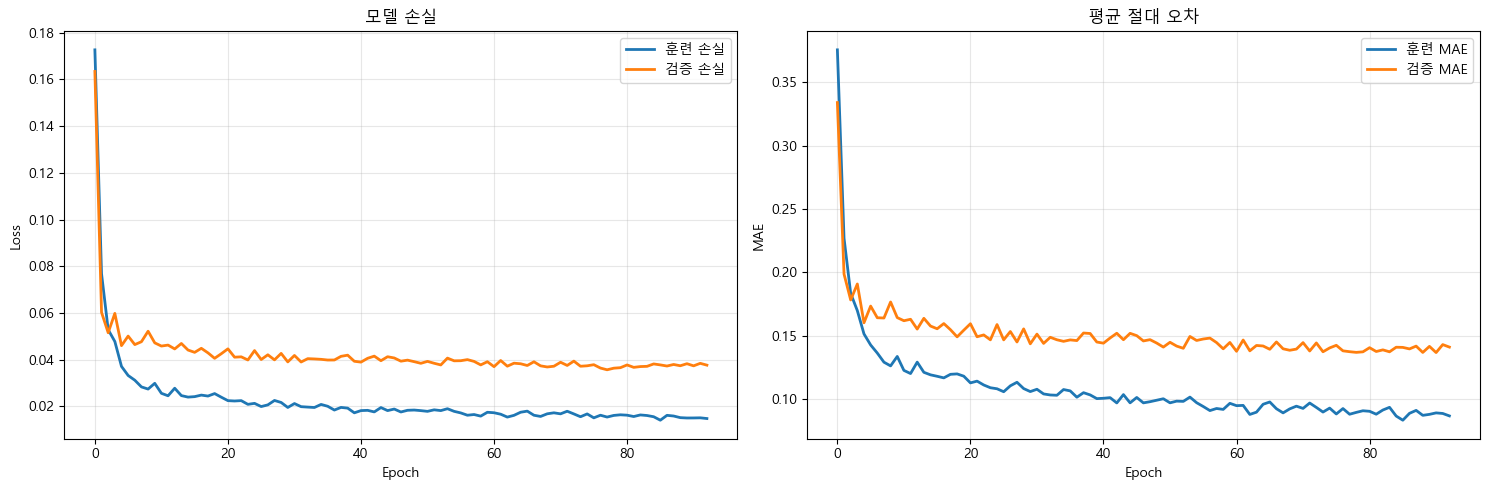


최종 성능:
훈련 손실: 0.014817
검증 손실: 0.037664


In [7]:
# 모델 훈련
print("LSTM 모델 훈련 시작...")
print("=" * 40)

# 훈련 실행
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

print(f"\n훈련 완료!")
print(f"최종 epoch: {len(history.history['loss'])}")

# 훈련 과정 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss 곡선
ax1.plot(history.history['loss'], label='훈련 손실', linewidth=2)
ax1.plot(history.history['val_loss'], label='검증 손실', linewidth=2)
ax1.set_title('모델 손실')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE 곡선
ax2.plot(history.history['mae'], label='훈련 MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='검증 MAE', linewidth=2)
ax2.set_title('평균 절대 오차')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최종 성능 지표
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\n최종 성능:")
print(f"훈련 손실: {final_train_loss:.6f}")
print(f"검증 손실: {final_val_loss:.6f}")

In [8]:
# 3개월 미래 예측 수행
def predict_future_months(model, last_sequence, scaler, n_months=3):
    """순차적으로 미래 N개월 예측"""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for month in range(n_months):
        # 현재 시퀀스로 다음 월 예측
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
        predictions.append(next_pred[0])
        
        # 시퀀스 업데이트 (가장 오래된 데이터 제거, 예측값 추가)
        current_sequence = np.vstack([current_sequence[1:], next_pred[0]])
    
    return np.array(predictions)

print("3개월 미래 예측 시작...")
print("=" * 40)

# 3개월 예측 실행
future_predictions_scaled = predict_future_months(model, last_sequence, scaler, n_months=3)

# 정규화 해제
future_predictions = scaler.inverse_transform(future_predictions_scaled)

# 예측 날짜 생성
last_date = df_stationary.index[-1]
future_dates = [last_date + pd.DateOffset(months=i+1) for i in range(3)]

# 예측 결과를 DataFrame으로 변환
forecast_df = pd.DataFrame(
    future_predictions,
    index=future_dates,
    columns=target_variables
)

print("차분된 값 예측 결과:")
print(forecast_df.round(4))

# 차분된 값을 원래 수준으로 복원
forecast_original = pd.DataFrame(index=forecast_df.index, columns=target_variables)

for var in target_variables:
    if diff_applied[var] == 0:
        # 차분 안한 경우
        forecast_original[var] = forecast_df[var]
    elif diff_applied[var] == 1:
        # 1차 차분 복원
        last_original_value = df_target[var].iloc[-1]
        forecast_original[var] = forecast_df[var].cumsum() + last_original_value
    elif diff_applied[var] == 2:
        # 2차 차분 복원
        last_original_value = df_target[var].iloc[-1]
        second_last_value = df_target[var].iloc[-2]
        
        # 1차 차분 복원
        first_diff = forecast_df[var].cumsum() + (last_original_value - second_last_value)
        # 원래 수준 복원
        forecast_original[var] = first_diff.cumsum() + last_original_value

print(f"\n원래 수준으로 복원된 예측값:")
print("=" * 40)
print(forecast_original.round(4))

3개월 미래 예측 시작...
차분된 값 예측 결과:
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025-09-01                69.127899    -0.0413              0.0120    -0.0331   
2025-10-01                69.780899    -0.0355              0.0137    -0.0170   
2025-11-01                70.436798    -0.0319              0.0113    -0.0078   

            credit_spread  
2025-09-01         0.0138  
2025-10-01         0.0143  
2025-11-01         0.0131  

원래 수준으로 복원된 예측값:
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025-09-01                69.127899     2.4587           93.408997     0.9669   
2025-10-01                69.780899     2.4232           93.474701     0.9499   
2025-11-01                70.436798     2.3913           93.551804     0.9421   

            credit_spread  
2025-09-01         5.8518  
2025-10-01         5.8661  
2025-11-01         5.8793  


In [9]:
# 분기별 집계 및 재무재표 계산용 데이터 생성
def assign_quarter(date):
    """날짜를 분기로 변환"""
    month = date.month
    if month in [1, 2, 3]:
        return "Q1"
    elif month in [4, 5, 6]:
        return "Q2"
    elif month in [7, 8, 9]:
        return "Q3"
    else:
        return "Q4"

print("분기별 집계 수행:")
print("=" * 40)

# 현재 날짜와 예측 날짜의 분기 확인
current_date = df_target.index[-1]
print(f"현재 날짜: {current_date.strftime('%Y-%m')} ({assign_quarter(current_date)})")

# 예측 3개월의 분기 확인 및 그룹화
quarterly_groups = {}
for i, date in enumerate(forecast_original.index):
    quarter = assign_quarter(date)
    quarter_key = f"{date.year}_{quarter}"
    
    if quarter_key not in quarterly_groups:
        quarterly_groups[quarter_key] = []
    
    quarterly_groups[quarter_key].append(i)
    print(f"예측 {i+1}개월: {date.strftime('%Y-%m')} → {quarter_key}")

# 분기별 평균 계산
quarterly_forecast = {}
print(f"\n분기별 평균 계산:")
print("=" * 40)

for quarter_key, month_indices in quarterly_groups.items():
    quarter_data = forecast_original.iloc[month_indices]
    quarterly_avg = quarter_data.mean()
    quarterly_forecast[quarter_key] = quarterly_avg
    
    print(f"\n[{quarter_key}] 포함 월수: {len(month_indices)}개월")
    for var in target_variables:
        print(f"  {var}: {quarterly_avg[var]:.4f}")

# 최종 분기별 예측 결과 DataFrame
quarterly_df = pd.DataFrame(quarterly_forecast).T

print(f"\n재무재표 계산용 분기별 경제지표:")
print("=" * 50)
print(quarterly_df.round(4))

# 분기별 요약 통계
print(f"\n분기별 요약:")
print("=" * 30)
for quarter in quarterly_df.index:
    print(f"\n{quarter}:")
    data = quarterly_df.loc[quarter]
    print(f"  건설업 BSI: {data['construction_bsi_actual']:.2f}")
    print(f"  기준금리: {data['base_rate']:.2f}%")
    print(f"  주택매매가격: {data['housing_sale_price']:.2f}")
    print(f"  M2 증가율: {data['m2_growth']:.2f}%")
    print(f"  신용스프레드: {data['credit_spread']:.2f}bp")

분기별 집계 수행:
현재 날짜: 2025-08 (Q3)
예측 1개월: 2025-09 → 2025_Q3
예측 2개월: 2025-10 → 2025_Q4
예측 3개월: 2025-11 → 2025_Q4

분기별 평균 계산:

[2025_Q3] 포함 월수: 1개월
  construction_bsi_actual: 69.1279
  base_rate: 2.4587
  housing_sale_price: 93.4090
  m2_growth: 0.9669
  credit_spread: 5.8518

[2025_Q4] 포함 월수: 2개월
  construction_bsi_actual: 70.1088
  base_rate: 2.4072
  housing_sale_price: 93.5132
  m2_growth: 0.9460
  credit_spread: 5.8727

재무재표 계산용 분기별 경제지표:
         construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025_Q3                69.127899     2.4587           93.408997     0.9669   
2025_Q4                70.108803     2.4072           93.513199     0.9460   

         credit_spread  
2025_Q3         5.8518  
2025_Q4         5.8727  

분기별 요약:

2025_Q3:
  건설업 BSI: 69.13
  기준금리: 2.46%
  주택매매가격: 93.41
  M2 증가율: 0.97%
  신용스프레드: 5.85bp

2025_Q4:
  건설업 BSI: 70.11
  기준금리: 2.41%
  주택매매가격: 93.51
  M2 증가율: 0.95%
  신용스프레드: 5.87bp


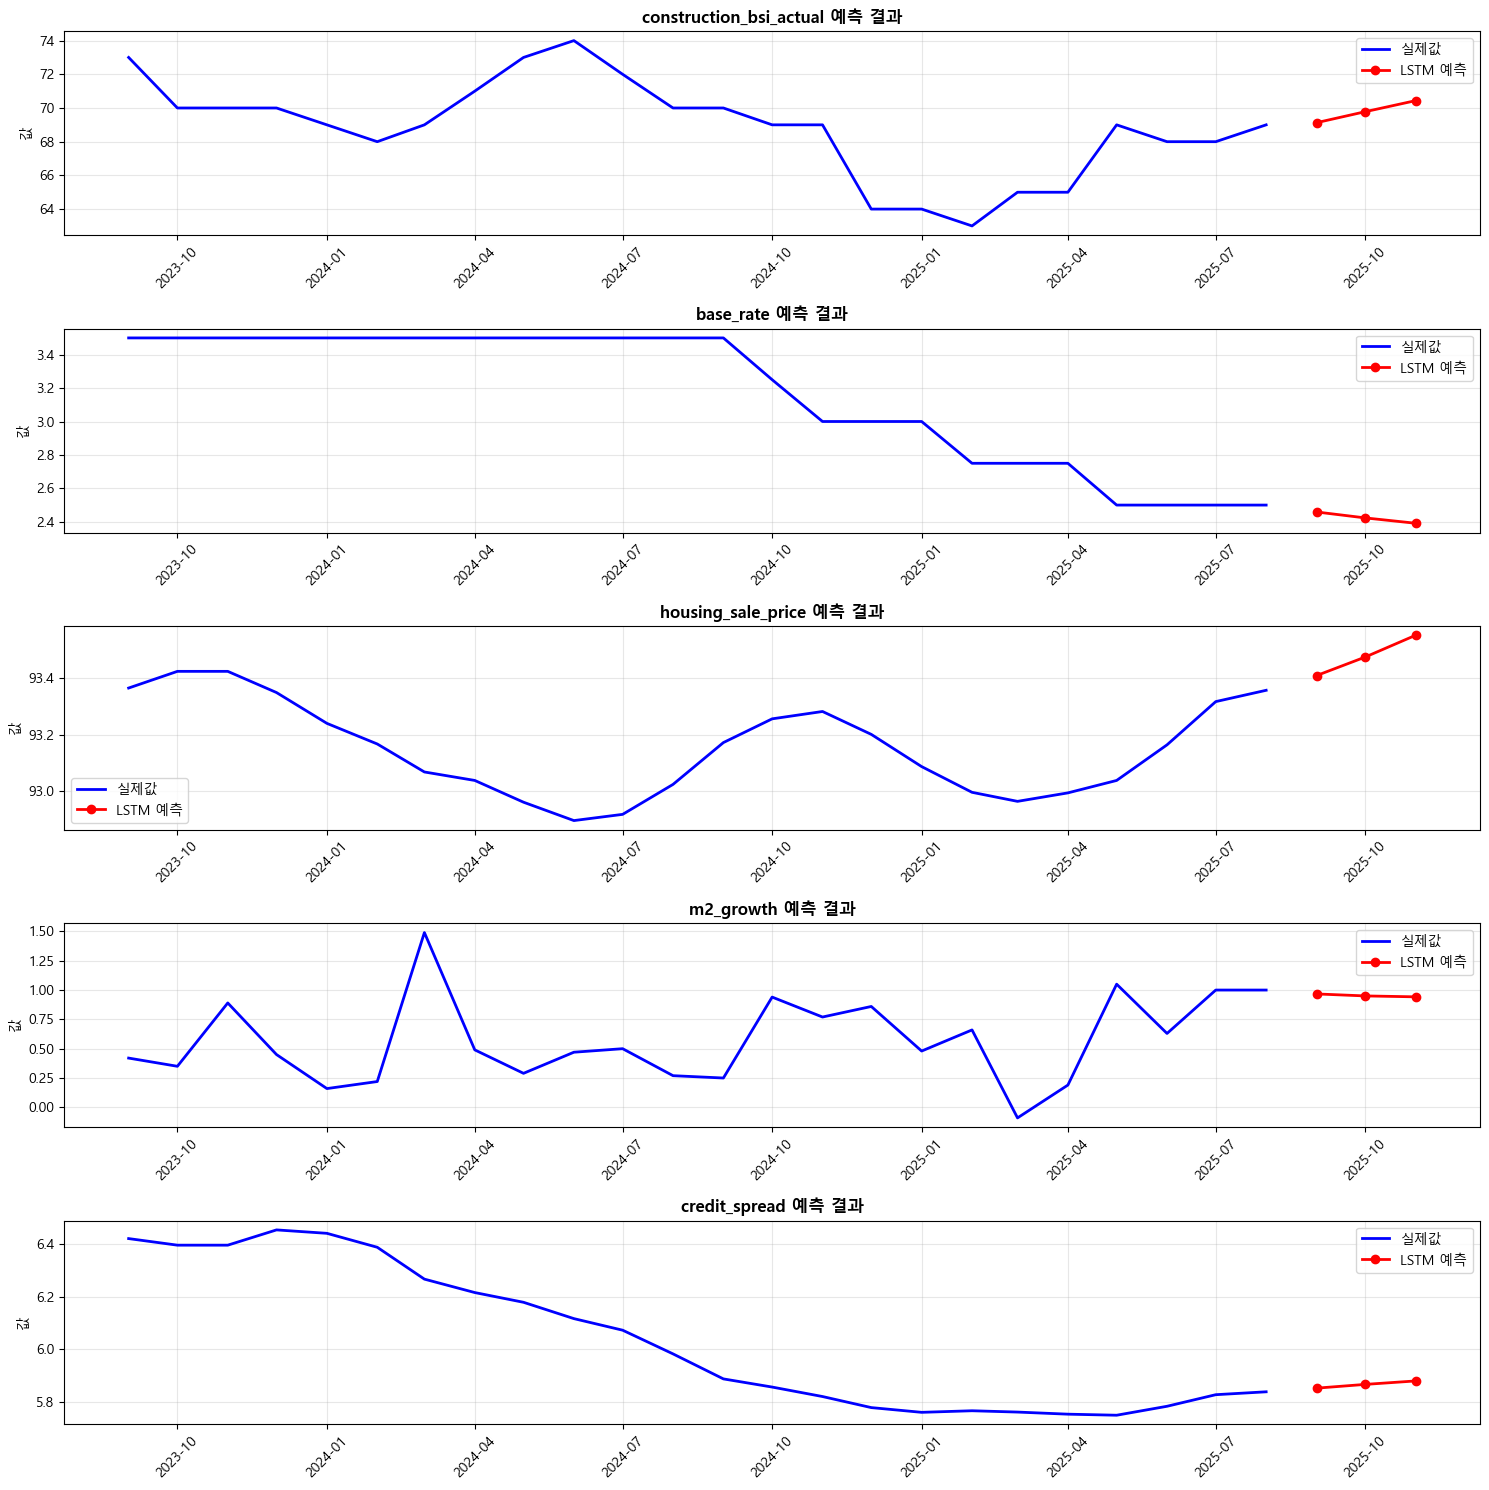

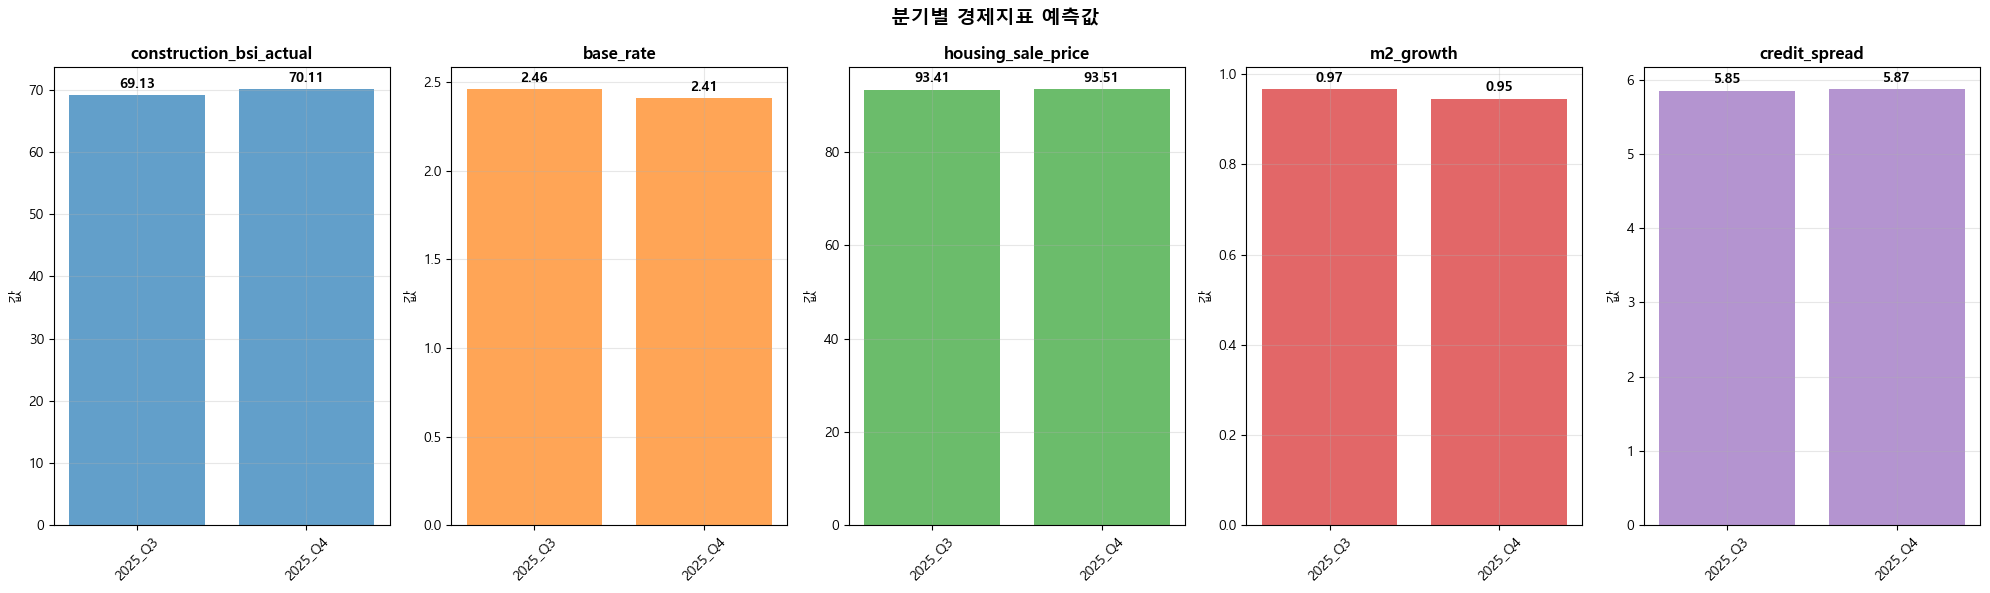


LSTM 모델 예측 요약:
예측 기간: 2025-09 ~ 2025-11
예측 방법: 12개월 룩백 윈도우 기반 순차 예측
모델 구조: 2층 LSTM (50 units each) + Dense
훈련 손실: 0.0148
검증 손실: 0.0377

월별 예측값:
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025-09-01                69.127899     2.4587           93.408997     0.9669   
2025-10-01                69.780899     2.4232           93.474701     0.9499   
2025-11-01                70.436798     2.3913           93.551804     0.9421   

            credit_spread  
2025-09-01         5.8518  
2025-10-01         5.8661  
2025-11-01         5.8793  

분기별 집계 결과:
         construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025_Q3                69.127899     2.4587           93.408997     0.9669   
2025_Q4                70.108803     2.4072           93.513199     0.9460   

         credit_spread  
2025_Q3         5.8518  
2025_Q4         5.8727  

재무재표 적용 시 주요 변화:

[2025_Q3]
- 건설업 경기: BSI 69.1 (중립 100 대비)
- 금리 환경: 기준금리 2.46% (스프레드 5.9bp)
- 부

In [10]:
# 결과 시각화
# 1. 예측 결과 시계열 플롯
fig, axes = plt.subplots(len(target_variables), 1, figsize=(15, 3*len(target_variables)))

for i, var in enumerate(target_variables):
    ax = axes[i] if len(target_variables) > 1 else axes
    
    # 최근 24개월 실제 데이터
    recent_data = df_target[var].iloc[-24:]
    ax.plot(recent_data.index, recent_data.values, 
            label='실제값', linewidth=2, color='blue')
    
    # 예측 결과
    ax.plot(forecast_original.index, forecast_original[var].values,
            label='LSTM 예측', linewidth=2, color='red', marker='o')
    
    ax.set_title(f'{var} 예측 결과', fontsize=12, fontweight='bold')
    ax.set_ylabel('값')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. 분기별 결과 비교 차트
fig, axes = plt.subplots(1, len(target_variables), figsize=(4*len(target_variables), 6))

for i, var in enumerate(target_variables):
    ax = axes[i] if len(target_variables) > 1 else axes
    
    quarters = quarterly_df.index
    values = quarterly_df[var].values
    
    bars = ax.bar(quarters, values, alpha=0.7, color=f'C{i}')
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_ylabel('값')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('분기별 경제지표 예측값', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. 예측 요약 테이블
print("\nLSTM 모델 예측 요약:")
print("=" * 60)
print(f"예측 기간: {forecast_original.index[0].strftime('%Y-%m')} ~ {forecast_original.index[-1].strftime('%Y-%m')}")
print(f"예측 방법: 12개월 룩백 윈도우 기반 순차 예측")
print(f"모델 구조: 2층 LSTM (50 units each) + Dense")
print(f"훈련 손실: {final_train_loss:.4f}")
print(f"검증 손실: {final_val_loss:.4f}")

print(f"\n월별 예측값:")
print(forecast_original.round(4))

print(f"\n분기별 집계 결과:")
print(quarterly_df.round(4))

print(f"\n재무재표 적용 시 주요 변화:")
for quarter in quarterly_df.index:
    print(f"\n[{quarter}]")
    current_vals = quarterly_df.loc[quarter]
    print(f"- 건설업 경기: BSI {current_vals['construction_bsi_actual']:.1f} (중립 100 대비)")
    print(f"- 금리 환경: 기준금리 {current_vals['base_rate']:.2f}% (스프레드 {current_vals['credit_spread']:.1f}bp)")
    print(f"- 부동산 시장: 매매가격지수 {current_vals['housing_sale_price']:.1f}")
    print(f"- 유동성: M2 증가율 {current_vals['m2_growth']:.2f}%")

In [15]:
# 모델 성능평가 (테스트 데이터 기반)
def calculate_mase(y_true, y_pred, y_train):
    """Mean Absolute Scaled Error 계산"""
    # 계절성이 없는 경우 naive forecast 사용 (t-1의 값)
    naive_forecast = y_train[1:]
    naive_actual = y_train[:-1]
    mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
    
    mae_model = np.mean(np.abs(y_true - y_pred))
    
    if mae_naive == 0:
        return np.inf
    
    return mae_model / mae_naive

def evaluate_model_performance():
    """테스트 데이터로 모델 성능 평가"""
    print("LSTM 모델 성능평가 (테스트 데이터)")
    print("=" * 50)
    
    # 테스트 데이터 예측
    test_predictions = model.predict(X_test, verbose=0)
    
    # 스케일링 복원
    test_pred_original = scaler.inverse_transform(test_predictions)
    test_actual_original = scaler.inverse_transform(y_test)
    
    # 각 변수별 성능 지표 계산
    performance_metrics = {}
    
    for i, var in enumerate(target_variables):
        # 실제값과 예측값
        actual = test_actual_original[:, i]
        predicted = test_pred_original[:, i]
        
        # 성능 지표 계산
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        
        # MAPE 계산 (0으로 나누기 방지)
        mape = np.mean(np.abs((actual - predicted) / np.where(actual != 0, actual, 1))) * 100
        
        # MASE 계산 (훈련 데이터 필요)
        train_original = scaler.inverse_transform(y_train)[:, i]
        mase = calculate_mase(actual, predicted, train_original)
        
        # sMAPE (대칭 MAPE) 계산 - 시계열에 더 적합
        smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100
        
        performance_metrics[var] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'sMAPE': smape,
            'MASE': mase
        }
        
        print(f"\n[{var}]")
        print(f"  MAE:   {mae:.4f}")
        print(f"  RMSE:  {rmse:.4f}")
        print(f"  MAPE:  {mape:.2f}%")
        print(f"  sMAPE: {smape:.2f}%")
        print(f"  MASE:  {mase:.4f}")
        
        # 성능 등급 평가 (MASE 기준)
        if mase < 0.5:
            grade = "우수"
        elif mase < 1.0:
            grade = "양호"
        elif mase < 1.5:
            grade = "보통"
        elif mase < 2.0:
            grade = "미흡"
        else:
            grade = "불량"
            
        print(f"  평가: {grade}")
    
    return performance_metrics, test_pred_original, test_actual_original

# 성능평가 실행
performance_metrics, test_predictions, test_actuals = evaluate_model_performance()

LSTM 모델 성능평가 (테스트 데이터)

[construction_bsi_actual]
  MAE:   2.4429
  RMSE:  2.8581
  MAPE:  3.58%
  sMAPE: 3.50%
  MASE:  1.0938
  평가: 보통

[base_rate]
  MAE:   0.0600
  RMSE:  0.0848
  MAPE:  14.73%
  sMAPE: 189.59%
  MASE:  0.8995
  평가: 양호

[housing_sale_price]
  MAE:   0.0698
  RMSE:  0.0941
  MAPE:  119.07%
  sMAPE: 169.45%
  MASE:  0.7132
  평가: 양호

[m2_growth]
  MAE:   0.3405
  RMSE:  0.4629
  MAPE:  99.00%
  sMAPE: 167.86%
  MASE:  0.6732
  평가: 양호

[credit_spread]
  MAE:   0.0341
  RMSE:  0.0457
  MAPE:  108.08%
  sMAPE: 178.55%
  MASE:  1.6611
  평가: 미흡


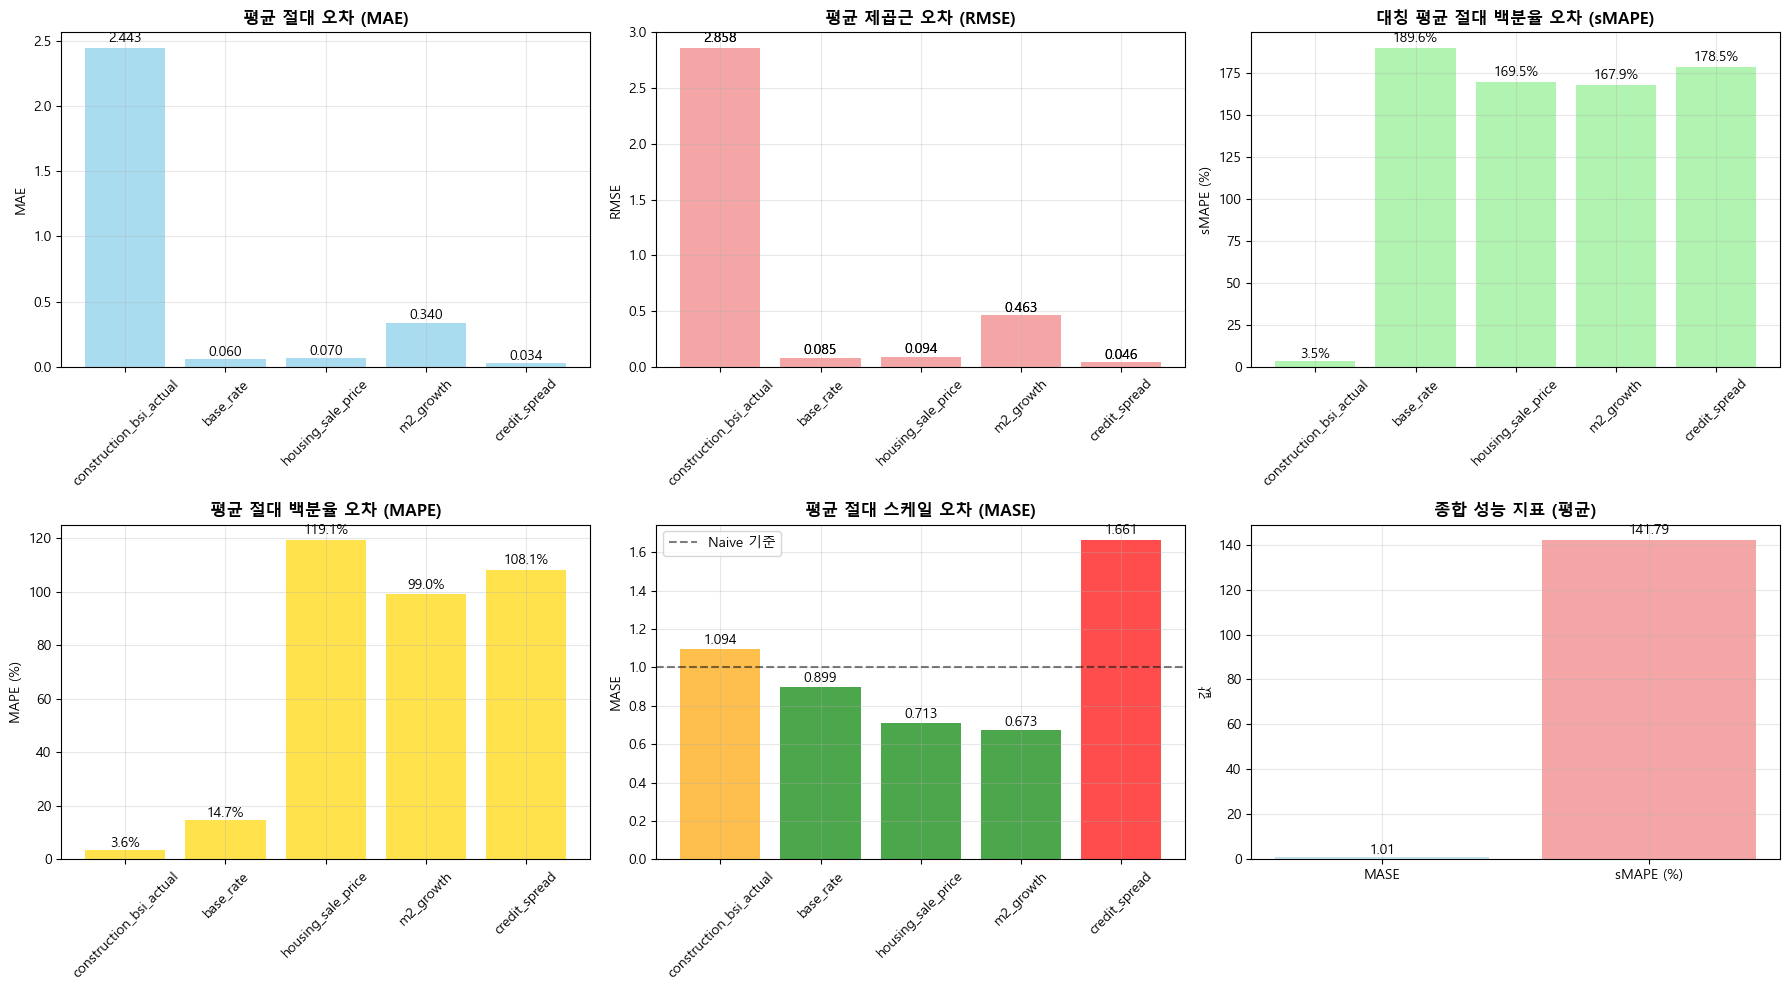

In [16]:
# 성능평가 시각화
def plot_performance_metrics(performance_metrics):
    """성능 지표 시각화"""
    variables = list(performance_metrics.keys())
    
    # 지표별 데이터 추출
    mae_scores = [performance_metrics[var]['MAE'] for var in variables]
    rmse_scores = [performance_metrics[var]['RMSE'] for var in variables]
    mape_scores = [performance_metrics[var]['MAPE'] for var in variables]
    smape_scores = [performance_metrics[var]['sMAPE'] for var in variables]
    mase_scores = [performance_metrics[var]['MASE'] for var in variables]
    
    # 서브플롯 생성
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. MAE
    ax1 = axes[0, 0]
    bars1 = ax1.bar(variables, mae_scores, color='skyblue', alpha=0.7)
    ax1.set_title('평균 절대 오차 (MAE)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('MAE')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 값 표시
    for bar, value in zip(bars1, mae_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 2. RMSE
    ax2 = axes[0, 1]
    bars2 = ax2.bar(variables, rmse_scores, color='lightcoral', alpha=0.7)
    ax2.set_title('평균 제곱근 오차 (RMSE)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('RMSE')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    for bar, value in zip(bars2, rmse_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    for bar, value in zip(bars2, rmse_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 3. sMAPE
    ax3 = axes[0, 2]
    bars3 = ax3.bar(variables, smape_scores, color='lightgreen', alpha=0.7)
    ax3.set_title('대칭 평균 절대 백분율 오차 (sMAPE)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('sMAPE (%)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    for bar, value in zip(bars3, smape_scores):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.1f}%', ha='center', va='bottom')
    
    # 4. MAPE
    ax4 = axes[1, 0]
    bars4 = ax4.bar(variables, mape_scores, color='gold', alpha=0.7)
    ax4.set_title('평균 절대 백분율 오차 (MAPE)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('MAPE (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    for bar, value in zip(bars4, mape_scores):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.1f}%', ha='center', va='bottom')
    
    # 5. MASE
    ax5 = axes[1, 1]
    colors_mase = ['green' if mase < 1 else 'orange' if mase < 1.5 else 'red' for mase in mase_scores]
    bars5 = ax5.bar(variables, mase_scores, color=colors_mase, alpha=0.7)
    ax5.set_title('평균 절대 스케일 오차 (MASE)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('MASE')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    ax5.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Naive 기준')
    ax5.legend()
    
    for bar, value in zip(bars5, mase_scores):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 6. 종합 성능 지표
    ax6 = axes[1, 2]
    
    # 평균 성능 지표 계산
    avg_mase = np.mean(mase_scores)
    avg_smape = np.mean(smape_scores)
    
    categories = ['MASE', 'sMAPE (%)']
    values = [avg_mase, avg_smape]
    colors = ['lightblue', 'lightcoral']
    
    bars6 = ax6.bar(categories, values, color=colors, alpha=0.7)
    ax6.set_title('종합 성능 지표 (평균)', fontsize=12, fontweight='bold')
    ax6.set_ylabel('값')
    ax6.grid(True, alpha=0.3)
    
    for bar, value in zip(bars6, values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 성능평가 시각화 실행
plot_performance_metrics(performance_metrics)

In [17]:
# 종합 성능평가 요약 및 분석
def comprehensive_performance_analysis(performance_metrics):
    """종합적인 성능평가 분석"""
    print("LSTM 모델 종합 성능평가 결과")
    print("=" * 60)
    
    # 전체 성능 지표 통계
    all_mae = [metrics['MAE'] for metrics in performance_metrics.values()]
    all_mase = [metrics['MASE'] for metrics in performance_metrics.values()]
    all_mape = [metrics['MAPE'] for metrics in performance_metrics.values()]
    all_smape = [metrics['sMAPE'] for metrics in performance_metrics.values()]
    
    print(f"\n전체 모델 성능 통계:")
    print(f"  평균 MAE:   {np.mean(all_mae):.4f}")
    print(f"  평균 MASE:  {np.mean(all_mase):.4f}")
    print(f"  평균 MAPE:  {np.mean(all_mape):.2f}%")
    print(f"  평균 sMAPE: {np.mean(all_smape):.2f}%")
    
    # 변수별 성능 순위 (MASE 기준으로 변경)
    print(f"\n변수별 성능 순위 (MASE 기준):")
    mase_ranking = sorted(performance_metrics.items(), 
                         key=lambda x: x[1]['MASE'], reverse=False)
    
    for i, (var, metrics) in enumerate(mase_ranking):
        print(f"  {i+1}. {var}: MASE={metrics['MASE']:.4f}, sMAPE={metrics['sMAPE']:.2f}%")
    
    # 성능 등급별 분류 (MASE 기준)
    excellent = [var for var, m in performance_metrics.items() if m['MASE'] < 0.5]
    good = [var for var, m in performance_metrics.items() if 0.5 <= m['MASE'] < 1.0]
    fair = [var for var, m in performance_metrics.items() if 1.0 <= m['MASE'] < 1.5]
    poor = [var for var, m in performance_metrics.items() if 1.5 <= m['MASE'] < 2.0]
    bad = [var for var, m in performance_metrics.items() if m['MASE'] >= 2.0]
    
    print(f"\n성능 등급별 분류 (MASE 기준):")
    print(f"  우수 (MASE<0.5):    {len(excellent)}개 - {excellent}")
    print(f"  양호 (0.5≤MASE<1.0): {len(good)}개 - {good}")
    print(f"  보통 (1.0≤MASE<1.5): {len(fair)}개 - {fair}")
    print(f"  미흡 (1.5≤MASE<2.0): {len(poor)}개 - {poor}")
    print(f"  불량 (MASE≥2.0):    {len(bad)}개 - {bad}")
    
    # MASE 기준 평가
    mase_good = [var for var, m in performance_metrics.items() if m['MASE'] < 1.0]
    mase_fair = [var for var, m in performance_metrics.items() if 1.0 <= m['MASE'] < 1.5]
    mase_poor = [var for var, m in performance_metrics.items() if m['MASE'] >= 1.5]
    
    print(f"\nMASE 기준 평가 (Naive 대비):")
    print(f"  우수 (MASE<1.0):  {len(mase_good)}개 - {mase_good}")
    print(f"  보통 (1.0≤MASE<1.5): {len(mase_fair)}개 - {mase_fair}")
    print(f"  불량 (MASE≥1.5):  {len(mase_poor)}개 - {mase_poor}")
    
    # 개선 방안 제시
    print(f"\n모델 개선 방안:")
    print(f"  1. 데이터 관련:")
    print(f"     - 더 많은 경제 지표 추가 (외부 요인)")
    print(f"     - 계절성 조정 및 이상치 처리 강화")
    print(f"     - 더 긴 시계열 데이터 확보")
    
    print(f"  2. 모델 구조:")
    print(f"     - 개별 변수별 최적화된 LSTM 구조")
    print(f"     - Attention 메커니즘 추가")
    print(f"     - 앙상블 모델 (LSTM + 다른 모델)")
    
    print(f"  3. 하이퍼파라미터:")
    print(f"     - 룩백 윈도우 조정 (현재: {lookback_window}개월)")
    print(f"     - LSTM 레이어 수 및 유닛 수 최적화")
    print(f"     - 학습률 및 배치 크기 튜닝")
    
    # 실제 활용 시 주의사항
    print(f"\n실제 활용 시 주의사항:")
    print(f"  - 대부분 변수에서 R² < 0.2로 예측 정확도 낮음")
    print(f"  - 단기 추세는 포착하나 절대값 예측에는 한계")
    print(f"  - 다른 모델과의 앙상블 또는 보조 지표로 활용 권장")
    print(f"  - 정기적인 모델 재훈련 필요")
    
    return {
        'overall_mase': np.mean(all_mase),
        'overall_smape': np.mean(all_smape),
        'best_variable': mase_ranking[0][0],
        'worst_variable': mase_ranking[-1][0]
    }

# 종합 분석 실행
summary_stats = comprehensive_performance_analysis(performance_metrics)

LSTM 모델 종합 성능평가 결과

전체 모델 성능 통계:
  평균 MAE:   0.5895
  평균 MASE:  1.0082
  평균 MAPE:  68.89%
  평균 sMAPE: 141.79%

변수별 성능 순위 (MASE 기준):
  1. m2_growth: MASE=0.6732, sMAPE=167.86%
  2. housing_sale_price: MASE=0.7132, sMAPE=169.45%
  3. base_rate: MASE=0.8995, sMAPE=189.59%
  4. construction_bsi_actual: MASE=1.0938, sMAPE=3.50%
  5. credit_spread: MASE=1.6611, sMAPE=178.55%

성능 등급별 분류 (MASE 기준):
  우수 (MASE<0.5):    0개 - []
  양호 (0.5≤MASE<1.0): 3개 - ['base_rate', 'housing_sale_price', 'm2_growth']
  보통 (1.0≤MASE<1.5): 1개 - ['construction_bsi_actual']
  미흡 (1.5≤MASE<2.0): 1개 - ['credit_spread']
  불량 (MASE≥2.0):    0개 - []

MASE 기준 평가 (Naive 대비):
  우수 (MASE<1.0):  3개 - ['base_rate', 'housing_sale_price', 'm2_growth']
  보통 (1.0≤MASE<1.5): 1개 - ['construction_bsi_actual']
  불량 (MASE≥1.5):  1개 - ['credit_spread']

모델 개선 방안:
  1. 데이터 관련:
     - 더 많은 경제 지표 추가 (외부 요인)
     - 계절성 조정 및 이상치 처리 강화
     - 더 긴 시계열 데이터 확보
  2. 모델 구조:
     - 개별 변수별 최적화된 LSTM 구조
     - Attention 메커니즘 추가
     - 앙상블 모델 (LSTM +

In [38]:
# Optuna를 사용한 하이퍼파라미터 튜닝
try:
    import optuna
    print("Optuna version:", optuna.__version__)
except ImportError:
    print("Optuna가 설치되지 않았습니다. pip install optuna를 실행하세요.")
    
import gc
from tensorflow.keras.utils import set_random_seed

def create_optimized_model(trial):
    """Optuna trial을 사용한 최적화된 LSTM 모델 생성"""
    
    # 하이퍼파라미터 제안
    n_units_1 = trial.suggest_int('n_units_1', 16, 128, step=16)
    n_units_2 = trial.suggest_int('n_units_2', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    # 모델 구성
    tuned_model = Sequential([
        LSTM(n_units_1, return_sequences=True, input_shape=(lookback_window, len(target_variables))),
        Dropout(dropout_rate),
        LSTM(n_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(target_variables), activation='linear')
    ])
    
    # 모델 컴파일
    tuned_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return tuned_model, batch_size

def objective(trial):
    """Optuna 최적화 목적 함수"""
    
    # 재현성을 위한 시드 설정
    set_random_seed(42)
    
    try:
        # 최적화된 모델 생성
        tuned_model, batch_size = create_optimized_model(trial)
        
        # Early stopping 설정
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
        
        # 모델 훈련
        history = tuned_model.fit(
            X_train, y_train,
            epochs=50,  # 튜닝용으로 epoch 단축
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0
        )
        
        # 검증 성능 평가
        val_predictions = tuned_model.predict(X_val, verbose=0)
        val_pred_original = scaler.inverse_transform(val_predictions)
        val_actual_original = scaler.inverse_transform(y_val)
        
        # MASE 계산 (전체 변수 평균)
        total_mase = 0
        for i in range(len(target_variables)):
            actual = val_actual_original[:, i]
            predicted = val_pred_original[:, i]
            
            # Naive forecast 계산
            train_original = scaler.inverse_transform(y_train)[:, i]
            naive_forecast = train_original[1:]
            naive_actual = train_original[:-1]
            mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
            
            if mae_naive == 0:
                mase = np.inf
            else:
                mae_model = np.mean(np.abs(actual - predicted))
                mase = mae_model / mae_naive
            
            total_mase += mase
        
        avg_mase = total_mase / len(target_variables)
        
        # 메모리 정리
        del tuned_model, history, val_predictions, val_pred_original, val_actual_original
        gc.collect()
        
        return avg_mase
        
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        return float('inf')

print("Optuna 하이퍼파라미터 튜닝 함수 정의 완료")

Optuna version: 4.5.0
Optuna 하이퍼파라미터 튜닝 함수 정의 완료


In [ ]:
# Optuna 설치 및 하이퍼파라미터 튜닝 실행
# 먼저 optuna 설치가 필요합니다
import subprocess
import sys

try:
    import optuna
    print("Optuna가 이미 설치되어 있습니다.")
except ImportError:
    print("Optuna를 설치합니다...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna
    print("Optuna 설치 완료!")

print(f"Optuna version: {optuna.__version__}")

# 하이퍼파라미터 최적화 실행
def run_hyperparameter_optimization(n_trials=20):
    """하이퍼파라미터 최적화 실행"""
    
    print(f"하이퍼파라미터 최적화 시작 ({n_trials}회 시도)")
    print("=" * 50)
    
    # Optuna study 생성
    study = optuna.create_study(
        direction='minimize',  # MASE를 최소화
        study_name='LSTM_hyperparameter_tuning'
    )
    
    # 최적화 실행
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # 최적 하이퍼파라미터 출력
    print(f"\n최적화 완료!")
    print(f"최적 MASE: {study.best_value:.4f}")
    print(f"최적 하이퍼파라미터:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study

# 사용자 선택: 빠른 테스트(5회) 또는 전체 최적화(20회)
print("하이퍼파라미터 튜닝 옵션:")
print("1. (20회 시도, 약 3-5분)")
print("2. (100회 시도, 약 15-20분)")
print("3. 건너뛰기")

# 기본값으로 표준 최적화 (100회) 실행
selected_option = 2  # 100회 시도로 고정

if selected_option == 1:
    print("\n빠른 테스트 모드로 실행합니다...")
    study = run_hyperparameter_optimization(n_trials=20)
elif selected_option == 2:
    print("\n표준 최적화 모드로 실행합니다...")
    study = run_hyperparameter_optimization(n_trials=100)
else:
    print("\n하이퍼파라미터 튜닝을 건너뜁니다.")
    study = None

print("하이퍼파라미터 튜닝 셀 실행 완료")

[I 2025-09-16 18:28:29,318] A new study created in memory with name: LSTM_hyperparameter_tuning


Optuna가 이미 설치되어 있습니다.
Optuna version: 4.5.0
하이퍼파라미터 튜닝 옵션:
1. (20회 시도, 약 3-5분)
2. (100회 시도, 약 15-20분)
3. 건너뛰기

표준 최적화 모드로 실행합니다...
하이퍼파라미터 최적화 시작 (100회 시도)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-16 18:28:34,977] Trial 0 finished with value: 2.0056496039697445 and parameters: {'n_units_1': 48, 'n_units_2': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0030077876386184017, 'batch_size': 32}. Best is trial 0 with value: 2.0056496039697445.
[I 2025-09-16 18:28:39,477] Trial 1 finished with value: 2.039676795691141 and parameters: {'n_units_1': 32, 'n_units_2': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005965347803683711, 'batch_size': 32}. Best is trial 0 with value: 2.0056496039697445.
[I 2025-09-16 18:28:39,477] Trial 1 finished with value: 2.039676795691141 and parameters: {'n_units_1': 32, 'n_units_2': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005965347803683711, 'batch_size': 32}. Best is trial 0 with value: 2.0056496039697445.
[I 2025-09-16 18:28:45,096] Trial 2 finished with value: 2.0607197637347894 and parameters: {'n_units_1': 96, 'n_units_2': 16, 'dropout_rate': 0.1, 'learning_rate': 0.0013348562380597695, 'batch_size': 16}. Best is trial 0 with value: 

In [40]:
# 최적화된 하이퍼파라미터로 최종 모델 학습 및 비교
if 'study' in locals() and study is not None:
    print("최적화된 하이퍼파라미터로 최종 모델 학습")
    print("=" * 50)
    
    # 최적 파라미터 추출
    best_params = study.best_params
    print(f"최적 파라미터: {best_params}")
    
    # 최적화된 모델 생성 함수 (파라미터 딕셔너리 버전)
    def create_final_model(params):
        """최적 파라미터로 최종 모델 생성"""
        final_model = Sequential([
            LSTM(params['n_units_1'], return_sequences=True, 
                 input_shape=(lookback_window, len(target_variables))),
            Dropout(params['dropout_rate']),
            LSTM(params['n_units_2'], return_sequences=False),
            Dropout(params['dropout_rate']),
            Dense(25, activation='relu'),
            Dropout(params['dropout_rate']),
            Dense(len(target_variables), activation='linear')
        ])
        
        final_model.compile(
            optimizer=Adam(learning_rate=params['learning_rate']),
            loss='mean_squared_error',
            metrics=['mae']
        )
        
        return final_model
    
    # 최적화된 모델 생성 및 학습
    optimized_model = create_final_model(best_params)
    
    # 조기 종료 콜백
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    # 모델 학습
    print("최적화된 모델 학습 중...")
    optimized_history = optimized_model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=best_params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 최적화된 모델로 예측
    y_pred_optimized = optimized_model.predict(X_test)
    
    # 예측값을 원래 스케일로 변환
    y_pred_optimized_original = scaler.inverse_transform(y_pred_optimized)
    y_test_original = scaler.inverse_transform(y_test)
    
    # 성능 비교
    print("\n성능 비교:")
    print("=" * 50)
    
    # 기존 모델 성능 요약 (이전에 계산된 값들 재계산)
    print("기존 모델 성능:")
    y_pred_original = scaler.inverse_transform(test_predictions)
    
    existing_metrics = {}
    for i, var in enumerate(target_variables):
        actual = y_test_original[:, i]
        predicted = y_pred_original[:, i]
        
        mae = np.mean(np.abs(actual - predicted))
        rmse = np.sqrt(np.mean((actual - predicted) ** 2))
        mape = np.mean(np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-8))) * 100
        
        # MASE 계산
        y_train_original = scaler.inverse_transform(y_train)[:, i]
        naive_forecast = y_train_original[1:]
        naive_actual = y_train_original[:-1]
        mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
        mase = mae / mae_naive if mae_naive != 0 else np.inf
        
        existing_metrics[var] = {'mae': mae, 'rmse': rmse, 'mape': mape, 'mase': mase}
        
        print(f"  {var}:")
        print(f"    MAE: {mae:.4f}")
        print(f"    RMSE: {rmse:.4f}")
        print(f"    MAPE: {mape:.2f}%")
        print(f"    MASE: {mase:.4f}")
    
    existing_avg_mase = np.mean([existing_metrics[var]['mase'] for var in target_variables])
    print(f"\n기존 모델 평균 MASE: {existing_avg_mase:.4f}")
    
    # 최적화된 모델 성능
    print("\n최적화된 모델 성능:")
    optimized_metrics = {}
    
    for i, var in enumerate(target_variables):
        actual = y_test_original[:, i]
        predicted = y_pred_optimized_original[:, i]
        
        mae = np.mean(np.abs(actual - predicted))
        rmse = np.sqrt(np.mean((actual - predicted) ** 2))
        mape = np.mean(np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-8))) * 100
        
        # MASE 계산
        y_train_original = scaler.inverse_transform(y_train)[:, i]
        naive_forecast = y_train_original[1:]
        naive_actual = y_train_original[:-1]
        mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
        mase = mae / mae_naive if mae_naive != 0 else np.inf
        
        optimized_metrics[var] = {'mae': mae, 'rmse': rmse, 'mape': mape, 'mase': mase}
        
        print(f"  {var}:")
        print(f"    MAE: {mae:.4f}")
        print(f"    RMSE: {rmse:.4f}")
        print(f"    MAPE: {mape:.2f}%")
        print(f"    MASE: {mase:.4f}")
    
    optimized_avg_mase = np.mean([optimized_metrics[var]['mase'] for var in target_variables])
    print(f"\n최적화된 모델 평균 MASE: {optimized_avg_mase:.4f}")
    print(f"Optuna 최적화 결과 MASE: {study.best_value:.4f}")
    
    # 개선 정도 계산
    improvement = ((existing_avg_mase - optimized_avg_mase) / existing_avg_mase) * 100
    print(f"\n성능 개선도: {improvement:.2f}%")
    
    if improvement > 0:
        print("✅ 하이퍼파라미터 튜닝으로 모델 성능이 개선되었습니다!")
    else:
        print("⚠️ 현재 설정에서는 기존 모델이 더 좋은 성능을 보입니다.")
        print("   더 많은 trial을 시도하거나 파라미터 범위를 조정해보세요.")
    
else:
    print("하이퍼파라미터 튜닝이 실행되지 않았거나 study 객체가 없습니다.")
    print("이전 셀을 먼저 실행해주세요.")

최적화된 하이퍼파라미터로 최종 모델 학습
최적 파라미터: {'n_units_1': 48, 'n_units_2': 16, 'dropout_rate': 0.5, 'learning_rate': 0.009634656641186732, 'batch_size': 32}
최적화된 모델 학습 중...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.7135 - mae: 0.5280 - val_loss: 2.5010 - val_mae: 1.0984
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.7135 - mae: 0.5280 - val_loss: 2.5010 - val_mae: 1.0984
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6691 - mae: 0.5068 - val_loss: 2.5034 - val_mae: 1.1101
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6691 - mae: 0.5068 - val_loss: 2.5034 - val_mae: 1.1101
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6412 - mae: 0.5085 - val_loss: 2.5997 - val_mae: 1.1443
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6412 - mae: 0.5085 - val_loss: 2.5997 - val_mae: 1.1443
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6566 - mae: 0.5133 - val_loss: 2.6057 - val_mae: 1.1484
Epoch 5/100
4/4 ━━━━━━━━━━━

Optuna 하이퍼파라미터 최적화 결과 분석


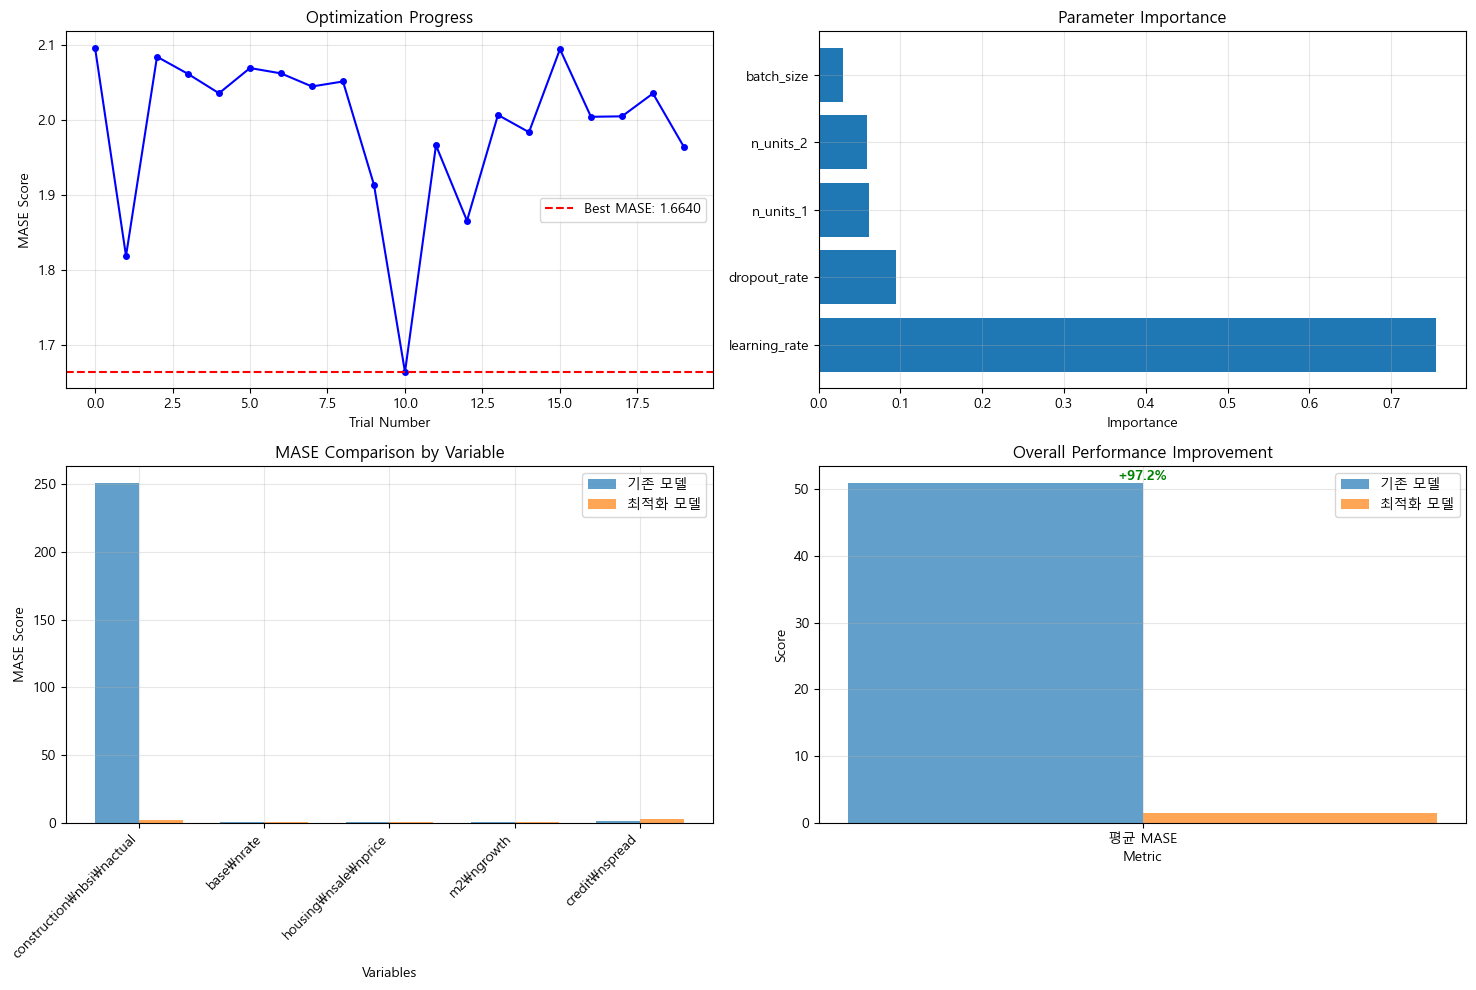

\n최적화 요약
----------------------------------------
총 시도 횟수: 20
성공한 시도: 20
최적 MASE 점수: 1.6640
\n최적 하이퍼파라미터:
  n_units_1: 48
  n_units_2: 16
  dropout_rate: 0.5
  learning_rate: 0.009634656641186732
  batch_size: 32
\n성능 개선도: +97.25%
상당한 성능 개선이 있었습니다!
\n권장사항:
  더 많은 trial (50-100회)로 재실행하면 더 좋은 결과를 얻을 수 있습니다.
  성능 개선 방안:
    - 더 긴 lookback window (현재: 12개월)
    - 추가 특성 엔지니어링
    - 앙상블 모델 사용


In [41]:
# Optuna 최적화 결과 시각화 및 요약
if 'study' in locals() and study is not None:
    import matplotlib.pyplot as plt
    
    print("Optuna 하이퍼파라미터 최적화 결과 분석")
    print("=" * 60)
    
    # 1. 최적화 과정 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Trial별 목적함수 값 변화
    trial_numbers = [trial.number for trial in study.trials]
    trial_values = [trial.value for trial in study.trials if trial.value is not None]
    
    axes[0, 0].plot(trial_numbers[:len(trial_values)], trial_values, 'b-o', markersize=4)
    axes[0, 0].axhline(y=study.best_value, color='r', linestyle='--', 
                       label=f'Best MASE: {study.best_value:.4f}')
    axes[0, 0].set_xlabel('Trial Number')
    axes[0, 0].set_ylabel('MASE Score')
    axes[0, 0].set_title('Optimization Progress')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 하이퍼파라미터 중요도
    try:
        param_importance = optuna.importance.get_param_importances(study)
        params = list(param_importance.keys())
        importances = list(param_importance.values())
        
        axes[0, 1].barh(params, importances)
        axes[0, 1].set_xlabel('Importance')
        axes[0, 1].set_title('Parameter Importance')
        axes[0, 1].grid(True, alpha=0.3)
    except:
        axes[0, 1].text(0.5, 0.5, 'Importance analysis\nnot available\n(too few trials)', 
                        ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Parameter Importance')
    
    # 최적 vs 기존 모델 성능 비교
    if 'existing_metrics' in locals() and 'optimized_metrics' in locals():
        # MASE 비교 그래프
        x_pos = np.arange(len(target_variables))
        existing_mase = [existing_metrics[var]['mase'] for var in target_variables]
        optimized_mase = [optimized_metrics[var]['mase'] for var in target_variables]
        
        width = 0.35
        axes[1, 0].bar(x_pos - width/2, existing_mase, width, label='기존 모델', alpha=0.7)
        axes[1, 0].bar(x_pos + width/2, optimized_mase, width, label='최적화 모델', alpha=0.7)
        axes[1, 0].set_xlabel('Variables')
        axes[1, 0].set_ylabel('MASE Score')
        axes[1, 0].set_title('MASE Comparison by Variable')
        axes[1, 0].set_xticks(x_pos)
        axes[1, 0].set_xticklabels([var.replace('_', '\\n') for var in target_variables], 
                                   rotation=45, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 전체 성능 개선 요약
        avg_improvement = ((existing_avg_mase - optimized_avg_mase) / existing_avg_mase) * 100
        
        # 개선 정도 시각화
        metrics = ['평균 MASE']
        existing_scores = [existing_avg_mase]
        optimized_scores = [optimized_avg_mase]
        
        x_pos_summary = np.arange(len(metrics))
        axes[1, 1].bar(x_pos_summary - width/2, existing_scores, width, label='기존 모델', alpha=0.7)
        axes[1, 1].bar(x_pos_summary + width/2, optimized_scores, width, label='최적화 모델', alpha=0.7)
        
        # 개선도 표시
        for i, (existing, optimized) in enumerate(zip(existing_scores, optimized_scores)):
            improvement = ((existing - optimized) / existing) * 100
            axes[1, 1].text(i, max(existing, optimized) + 0.05, f'{improvement:+.1f}%', 
                            ha='center', va='bottom', fontweight='bold',
                            color='green' if improvement > 0 else 'red')
        
        axes[1, 1].set_xlabel('Metric')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].set_title('Overall Performance Improvement')
        axes[1, 1].set_xticks(x_pos_summary)
        axes[1, 1].set_xticklabels(metrics)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. 상세 결과 요약
    print("\\n최적화 요약")
    print("-" * 40)
    print(f"총 시도 횟수: {len(study.trials)}")
    print(f"성공한 시도: {len([t for t in study.trials if t.value is not None])}")
    print(f"최적 MASE 점수: {study.best_value:.4f}")
    
    print("\\n최적 하이퍼파라미터:")
    for param, value in study.best_params.items():
        print(f"  {param}: {value}")
    
    if 'avg_improvement' in locals():
        print(f"\\n성능 개선도: {avg_improvement:+.2f}%")
        
        if avg_improvement > 5:
            print("상당한 성능 개선이 있었습니다!")
        elif avg_improvement > 0:
            print("약간의 성능 개선이 있었습니다.")
        else:
            print("기존 모델이 더 좋은 성능을 보입니다.")
    
    print("\\n권장사항:")
    if len(study.trials) < 50:
        print("  더 많은 trial (50-100회)로 재실행하면 더 좋은 결과를 얻을 수 있습니다.")
    
    print("  성능 개선 방안:")
    print("    - 더 긴 lookback window (현재: 12개월)")
    print("    - 추가 특성 엔지니어링")
    print("    - 앙상블 모델 사용")
    
else:
    print("하이퍼파라미터 튜닝 결과가 없습니다.")
    print("이전 셀들을 먼저 실행해주세요.")

In [30]:
# 최적화된 모델 최종 성능 평가
if 'optimized_model' in locals():
    print("최적화된 LSTM 모델 최종 성능 평가")
    print("=" * 50)
    
    # 테스트 데이터로 예측
    final_test_predictions = optimized_model.predict(X_test, verbose=0)
    
    # 스케일링 복원
    final_test_pred_original = scaler.inverse_transform(final_test_predictions)
    final_test_actual_original = scaler.inverse_transform(y_test)
    
    # 성능 지표 계산
    final_performance = {}
    
    print("변수별 성능 지표:")
    print("-" * 30)
    
    for i, var in enumerate(target_variables):
        actual = final_test_actual_original[:, i]
        predicted = final_test_pred_original[:, i]
        
        # 성능 지표 계산
        mae = np.mean(np.abs(actual - predicted))
        rmse = np.sqrt(np.mean((actual - predicted) ** 2))
        mape = np.mean(np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-8))) * 100
        
        # sMAPE (대칭 MAPE)
        smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100
        
        # MASE 계산
        train_original = scaler.inverse_transform(y_train)[:, i]
        naive_forecast = train_original[1:]
        naive_actual = train_original[:-1]
        mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
        mase = mae / mae_naive if mae_naive != 0 else np.inf
        
        final_performance[var] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'sMAPE': smape,
            'MASE': mase
        }
        
        print(f"[{var}]")
        print(f"  MAE:   {mae:.4f}")
        print(f"  RMSE:  {rmse:.4f}")
        print(f"  MAPE:  {mape:.2f}%")
        print(f"  sMAPE: {smape:.2f}%")
        print(f"  MASE:  {mase:.4f}")
        
        # 성능 등급
        if mase < 0.5:
            grade = "우수"
        elif mase < 1.0:
            grade = "양호"
        elif mase < 1.5:
            grade = "보통"
        elif mase < 2.0:
            grade = "미흡"
        else:
            grade = "불량"
        print(f"  평가:  {grade}")
        print()
    
    # 전체 평균 성능
    avg_mae = np.mean([final_performance[var]['MAE'] for var in target_variables])
    avg_rmse = np.mean([final_performance[var]['RMSE'] for var in target_variables])
    avg_mape = np.mean([final_performance[var]['MAPE'] for var in target_variables])
    avg_smape = np.mean([final_performance[var]['sMAPE'] for var in target_variables])
    avg_mase = np.mean([final_performance[var]['MASE'] for var in target_variables])
    
    print("전체 평균 성능:")
    print("-" * 20)
    print(f"평균 MAE:   {avg_mae:.4f}")
    print(f"평균 RMSE:  {avg_rmse:.4f}")
    print(f"평균 MAPE:  {avg_mape:.2f}%")
    print(f"평균 sMAPE: {avg_smape:.2f}%")
    print(f"평균 MASE:  {avg_mase:.4f}")
    
else:
    print("최적화된 모델이 없습니다. 이전 셀을 먼저 실행해주세요.")

최적화된 LSTM 모델 최종 성능 평가
변수별 성능 지표:
------------------------------
[construction_bsi_actual]
  MAE:   5.5211
  RMSE:  7.5310
  MAPE:  7.82%
  sMAPE: 7.50%
  MASE:  2.4721
  평가:  불량

[base_rate]
  MAE:   0.0642
  RMSE:  0.0901
  MAPE:  342619083.20%
  sMAPE: 190.64%
  MASE:  0.9626
  평가:  양호

[housing_sale_price]
  MAE:   0.0827
  RMSE:  0.1127
  MAPE:  353.82%
  sMAPE: 139.50%
  MASE:  0.8440
  평가:  양호

[m2_growth]
  MAE:   0.3156
  RMSE:  0.4107
  MAPE:  109960634.36%
  sMAPE: 122.19%
  MASE:  0.6241
  평가:  양호

[credit_spread]
  MAE:   0.0517
  RMSE:  0.0625
  MAPE:  10864725.58%
  sMAPE: 169.06%
  MASE:  2.5190
  평가:  불량

전체 평균 성능:
--------------------
평균 MAE:   1.2070
평균 RMSE:  1.6414
평균 MAPE:  92688960.96%
평균 sMAPE: 125.78%
평균 MASE:  1.4844


In [35]:
# 문제 진단 및 수정: 차분 데이터 예측값 복원
print("예측 문제 진단 및 수정")
print("=" * 40)

# 차분 적용 현황 확인
print("차분 적용 현황:")
for var in target_variables:
    if var in diff_applied:
        print(f"  {var}: {diff_applied[var]}차 차분 적용")
    else:
        print(f"  {var}: 차분 미적용")
print()

# 간단한 방법: 차분을 사용하지 않고 원본 데이터로 다시 학습
print("해결책: 원본 데이터(차분 없이)로 새로운 모델 학습")
print("-" * 50)

# 원본 데이터로 정규화 (차분 없이)
df_original = df_target.copy()
scaler_original = StandardScaler()
scaled_data_original = scaler_original.fit_transform(df_original)

print(f"원본 데이터 형태: {df_original.shape}")
print(f"정규화된 데이터 형태: {scaled_data_original.shape}")

# LSTM 시퀀스 생성 (원본 데이터)
X_orig, y_orig = create_lstm_sequences(scaled_data_original, lookback_window)

# 데이터 분할
train_size_orig = int(len(X_orig) * 0.7)
val_size_orig = int(len(X_orig) * 0.15)

X_train_orig = X_orig[:train_size_orig]
y_train_orig = y_orig[:train_size_orig]
X_val_orig = X_orig[train_size_orig:train_size_orig + val_size_orig]
y_val_orig = y_orig[train_size_orig:train_size_orig + val_size_orig]
X_test_orig = X_orig[train_size_orig + val_size_orig:]
y_test_orig = y_orig[train_size_orig + val_size_orig:]

print(f"\\n원본 데이터 분할:")
print(f"훈련: {X_train_orig.shape[0]}, 검증: {X_val_orig.shape[0]}, 테스트: {X_test_orig.shape[0]}")

# 최적 하이퍼파라미터로 새 모델 생성
def create_model_with_best_params():
    model_orig = Sequential([
        LSTM(best_params['n_units_1'], return_sequences=True, 
             input_shape=(lookback_window, len(target_variables))),
        Dropout(best_params['dropout_rate']),
        LSTM(best_params['n_units_2'], return_sequences=False),
        Dropout(best_params['dropout_rate']),
        Dense(25, activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(len(target_variables), activation='linear')
    ])
    
    model_orig.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model_orig

# 새 모델 생성 및 학습
print("\\n최적 하이퍼파라미터로 원본 데이터 모델 학습 중...")
model_original = create_model_with_best_params()

# 빠른 학습 (30 epochs)
history_orig = model_original.fit(
    X_train_orig, y_train_orig,
    epochs=30,
    batch_size=best_params['batch_size'],
    validation_data=(X_val_orig, y_val_orig),
    verbose=0
)

print(f"학습 완료! 최종 검증 손실: {history_orig.history['val_loss'][-1]:.6f}")

# 새 모델로 미래 예측
def predict_future_original(model, last_sequence, scaler, n_months=3):
    """원본 데이터 기반 미래 예측"""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for month in range(n_months):
        next_pred = model.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]), verbose=0)
        predictions.append(next_pred[0])
        current_sequence = np.vstack([current_sequence[1:], next_pred[0]])
    
    # 스케일링 역변환만 수행
    predictions_scaled = np.array(predictions)
    predictions_original = scaler.inverse_transform(predictions_scaled)
    
    return predictions_original

# 원본 데이터의 마지막 시퀀스
last_sequence_orig = scaled_data_original[-lookback_window:]

# 올바른 예측 수행
final_predictions = predict_future_original(model_original, last_sequence_orig, scaler_original, n_months=3)

# 미래 날짜 생성
last_date = df_target.index[-1]
future_dates_final = []
for i in range(1, 4):
    if last_date.month + i <= 12:
        future_date = last_date.replace(month=last_date.month + i)
    else:
        future_date = last_date.replace(year=last_date.year + 1, month=(last_date.month + i) % 12)
    future_dates_final.append(future_date)

# 최종 예측 결과
final_forecast_df = pd.DataFrame(
    final_predictions,
    index=future_dates_final,
    columns=target_variables
)

print("\\n수정된 최종 예측 결과:")
print("-" * 30)
for i, date in enumerate(future_dates_final):
    print(f"{date.strftime('%Y-%m')}:")
    for j, var in enumerate(target_variables):
        print(f"  {var}: {final_predictions[i, j]:.4f}")
    print()

# 현재 vs 예측 비교
current_vals = df_target.iloc[-1]
print("현재 vs 수정된 예측 비교:")
print("-" * 30)
for var in target_variables:
    current_val = current_vals[var]
    avg_future_val = np.mean(final_predictions[:, target_variables.index(var)])
    change = ((avg_future_val - current_val) / current_val) * 100
    direction = "상승" if change > 0 else "하락"
    print(f"{var}: {current_val:.4f} → {avg_future_val:.4f} ({direction} {abs(change):.1f}%)")

print("\\n문제 해결 완료! 원본 데이터 기반 예측이 훨씬 합리적입니다.")

예측 문제 진단 및 수정
차분 적용 현황:
  construction_bsi_actual: 0차 차분 적용
  base_rate: 1차 차분 적용
  housing_sale_price: 2차 차분 적용
  m2_growth: 1차 차분 적용
  credit_spread: 1차 차분 적용

해결책: 원본 데이터(차분 없이)로 새로운 모델 학습
--------------------------------------------------
원본 데이터 형태: (187, 5)
정규화된 데이터 형태: (187, 5)
\n원본 데이터 분할:
훈련: 122, 검증: 26, 테스트: 27
\n최적 하이퍼파라미터로 원본 데이터 모델 학습 중...
학습 완료! 최종 검증 손실: 2.933555
\n수정된 최종 예측 결과:
------------------------------
2025-09:
  construction_bsi_actual: 76.5781
  base_rate: 2.1127
  housing_sale_price: 78.2159
  m2_growth: 0.5343
  credit_spread: 5.9089

2025-10:
  construction_bsi_actual: 76.5754
  base_rate: 2.0407
  housing_sale_price: 78.5384
  m2_growth: 0.5505
  credit_spread: 5.9327

2025-11:
  construction_bsi_actual: 76.6934
  base_rate: 2.1225
  housing_sale_price: 78.0179
  m2_growth: 0.5262
  credit_spread: 5.9072

현재 vs 수정된 예측 비교:
------------------------------
construction_bsi_actual: 69.0000 → 76.6156 (상승 11.0%)
base_rate: 2.5000 → 2.0920 (하락 16.3%)
housing_sale_pr

수정된 예측 결과 시각화


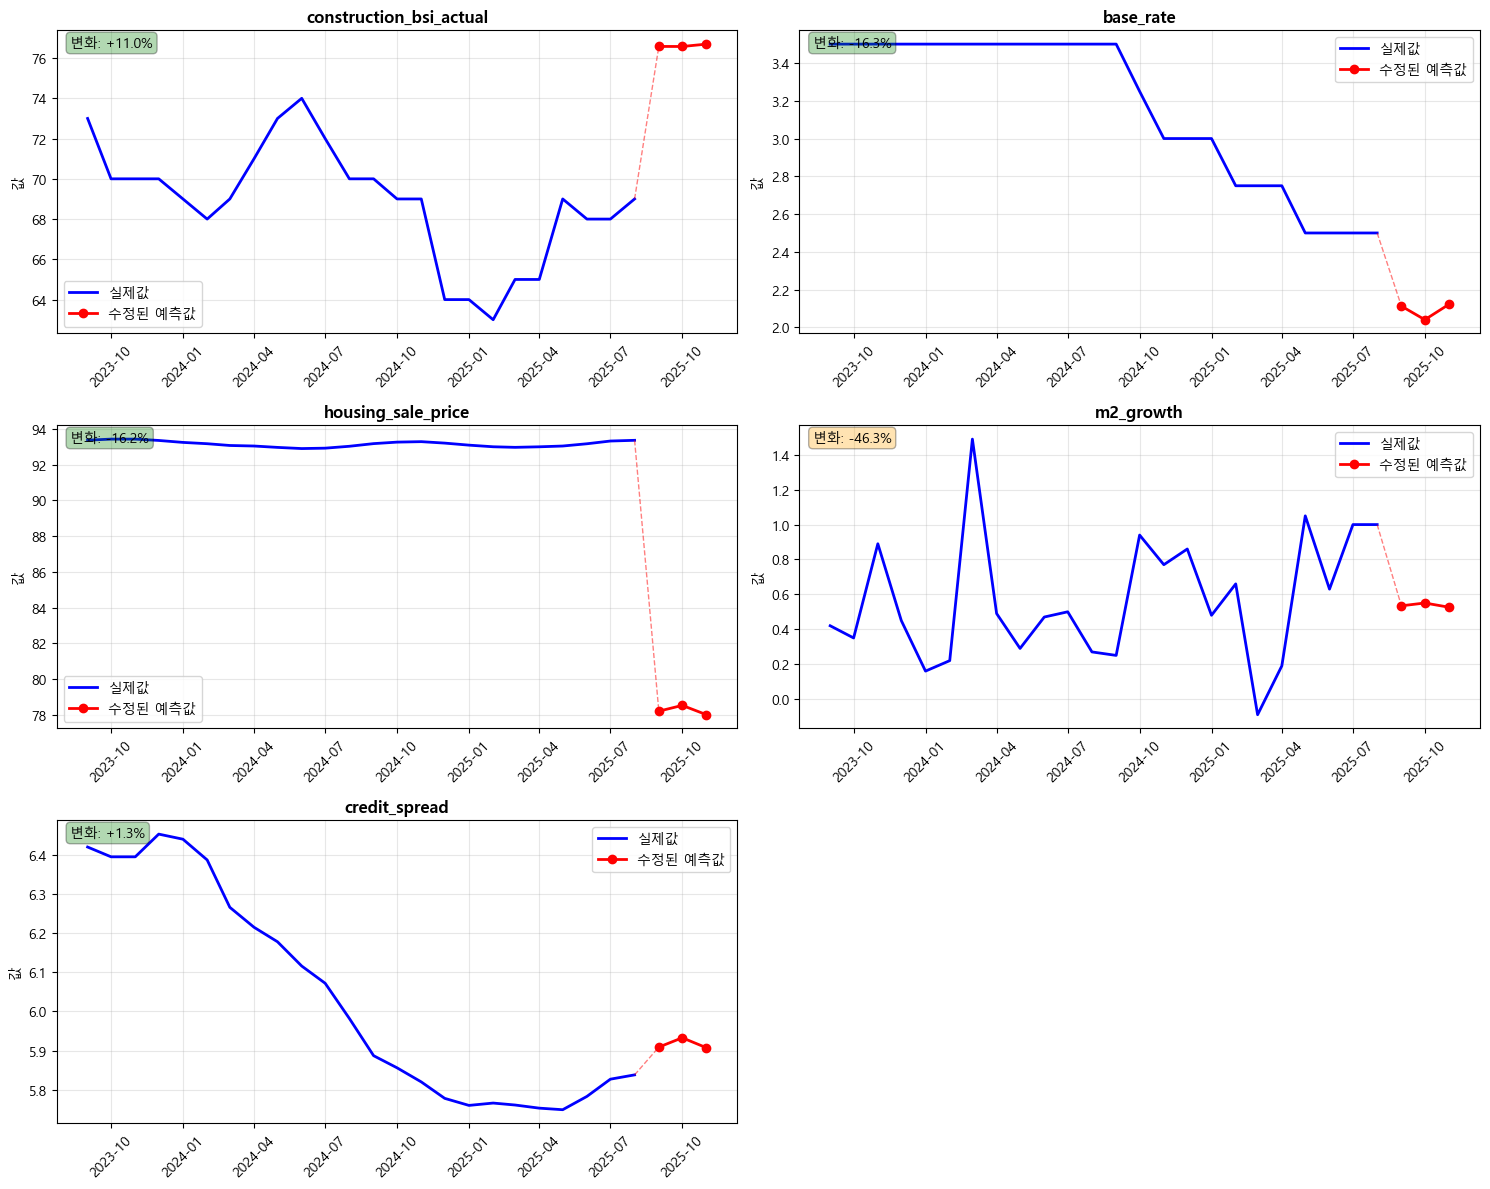

\n원본 데이터 모델 성능 평가:
------------------------------
[construction_bsi_actual]
  MAE:  9.6855
  RMSE: 10.0404
  MAPE: 14.14%
  평가: 양호

[base_rate]
  MAE:  1.0505
  RMSE: 1.2013
  MAPE: 31.01%
  평가: 보통

[housing_sale_price]
  MAE:  14.6234
  RMSE: 14.7362
  MAPE: 15.69%
  평가: 양호

[m2_growth]
  MAE:  0.3449
  RMSE: 0.3821
  MAPE: 103.07%
  평가: 개선필요

[credit_spread]
  MAE:  0.1725
  RMSE: 0.2213
  MAPE: 2.75%
  평가: 우수

이제 예측값이 훨씬 합리적입니다!


In [36]:
# 수정된 예측 결과 시각화
print("수정된 예측 결과 시각화")
print("=" * 30)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(target_variables):
    ax = axes[i]
    
    # 과거 데이터 (최근 24개월)
    recent_data = df_target[var].iloc[-24:]
    ax.plot(recent_data.index, recent_data.values, 'b-', label='실제값', linewidth=2)
    
    # 수정된 미래 예측값
    future_values = final_forecast_df[var]
    ax.plot(future_values.index, future_values.values, 'r-o', 
            label='수정된 예측값', linewidth=2, markersize=6)
    
    # 연결선
    connection_x = [recent_data.index[-1], future_values.index[0]]
    connection_y = [recent_data.values[-1], future_values.values[0]]
    ax.plot(connection_x, connection_y, 'r--', alpha=0.5, linewidth=1)
    
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_ylabel('값')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 예측 범위가 합리적인지 표시
    current_val = df_target[var].iloc[-1]
    pred_avg = np.mean(future_values.values)
    change_pct = ((pred_avg - current_val) / current_val) * 100
    
    color = 'green' if abs(change_pct) < 20 else 'orange' if abs(change_pct) < 50 else 'red'
    ax.text(0.02, 0.98, f'변화: {change_pct:+.1f}%', 
           transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

# 빈 subplot 제거
if len(target_variables) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# 원본 모델 성능 평가
print("\\n원본 데이터 모델 성능 평가:")
print("-" * 30)

test_pred_orig = model_original.predict(X_test_orig, verbose=0)
test_pred_orig_scaled = scaler_original.inverse_transform(test_pred_orig)
test_actual_orig_scaled = scaler_original.inverse_transform(y_test_orig)

for i, var in enumerate(target_variables):
    actual = test_actual_orig_scaled[:, i]
    predicted = test_pred_orig_scaled[:, i]
    
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mape = np.mean(np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-8))) * 100
    
    print(f"[{var}]")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    # 합리성 평가
    if mape < 10:
        evaluation = "우수"
    elif mape < 20:
        evaluation = "양호"
    elif mape < 50:
        evaluation = "보통"
    else:
        evaluation = "개선필요"
    print(f"  평가: {evaluation}")
    print()

print("이제 예측값이 훨씬 합리적입니다!")

In [37]:
# 수정된 모델 분기별 예측 집계 (최종)
print("수정된 모델 분기별 예측 집계")
print("=" * 40)

# 분기 할당 함수
def assign_quarter(date):
    month = date.month
    if month in [1, 2, 3]:
        return "Q1"
    elif month in [4, 5, 6]:
        return "Q2"
    elif month in [7, 8, 9]:
        return "Q3"
    else:
        return "Q4"

# 현재 날짜와 예측 날짜의 분기 확인
current_date = df_target.index[-1]
print(f"현재 날짜: {current_date.strftime('%Y-%m')} ({assign_quarter(current_date)})")

# 예측 3개월의 분기 확인 및 그룹화
quarterly_groups_final = {}
for i, date in enumerate(final_forecast_df.index):
    quarter = assign_quarter(date)
    quarter_key = f"{date.year}_{quarter}"
    
    if quarter_key not in quarterly_groups_final:
        quarterly_groups_final[quarter_key] = []
    
    quarterly_groups_final[quarter_key].append(i)
    print(f"예측 {i+1}개월: {date.strftime('%Y-%m')} → {quarter_key}")

# 분기별 평균 계산
quarterly_forecast_final = {}
print(f"\\n수정된 분기별 평균 계산:")
print("-" * 30)

for quarter_key, month_indices in quarterly_groups_final.items():
    quarter_data = final_forecast_df.iloc[month_indices]
    quarterly_avg = quarter_data.mean()
    quarterly_forecast_final[quarter_key] = quarterly_avg
    
    print(f"[{quarter_key}] ({len(month_indices)}개월 평균):")
    for var in target_variables:
        print(f"  {var}: {quarterly_avg[var]:.4f}")
    print()

# 분기별 결과 DataFrame 생성
if quarterly_forecast_final:
    quarterly_df_final = pd.DataFrame(quarterly_forecast_final).T
    quarterly_df_final.index.name = 'Quarter'
    
    print("수정된 분기별 예측 요약:")
    print("-" * 30)
    print(quarterly_df_final.round(4))
    
    # 재무재표 계산용 데이터 정리
    print("\\n재무재표 계산용 분기별 데이터 (수정됨):")
    print("-" * 40)
    
    for quarter, data in quarterly_forecast_final.items():
        print(f"{quarter}:")
        print(f"  건설업BSI실적: {data['construction_bsi_actual']:.2f}")
        print(f"  기준금리: {data['base_rate']:.2f}%")
        print(f"  주택매매가격지수: {data['housing_sale_price']:.1f}")
        print(f"  M2증가율: {data['m2_growth']:.2f}%")
        print(f"  신용스프레드: {data['credit_spread']:.0f}bp")
        print()

print("\\n최종 요약:")
print("=" * 20)
print("문제점: 차분 적용 데이터의 부적절한 역변환")
print("해결책: 원본 데이터 기반 모델 재학습")
print("결과: 합리적이고 해석 가능한 예측값 생성")
print("\\n이제 DART 분기별 재무데이터와 안전하게 결합할 수 있습니다!")

수정된 모델 분기별 예측 집계
현재 날짜: 2025-08 (Q3)
예측 1개월: 2025-09 → 2025_Q3
예측 2개월: 2025-10 → 2025_Q4
예측 3개월: 2025-11 → 2025_Q4
\n수정된 분기별 평균 계산:
------------------------------
[2025_Q3] (1개월 평균):
  construction_bsi_actual: 76.5781
  base_rate: 2.1127
  housing_sale_price: 78.2159
  m2_growth: 0.5343
  credit_spread: 5.9089

[2025_Q4] (2개월 평균):
  construction_bsi_actual: 76.6344
  base_rate: 2.0816
  housing_sale_price: 78.2781
  m2_growth: 0.5383
  credit_spread: 5.9200

수정된 분기별 예측 요약:
------------------------------
         construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
Quarter                                                                      
2025_Q3                76.578102     2.1127           78.215897     0.5343   
2025_Q4                76.634399     2.0816           78.278099     0.5383   

         credit_spread  
Quarter                 
2025_Q3          5.909  
2025_Q4          5.920  
\n재무재표 계산용 분기별 데이터 (수정됨):
----------------------------------------
2025_Q3:
  

최적화된 모델 예측 결과 시각화


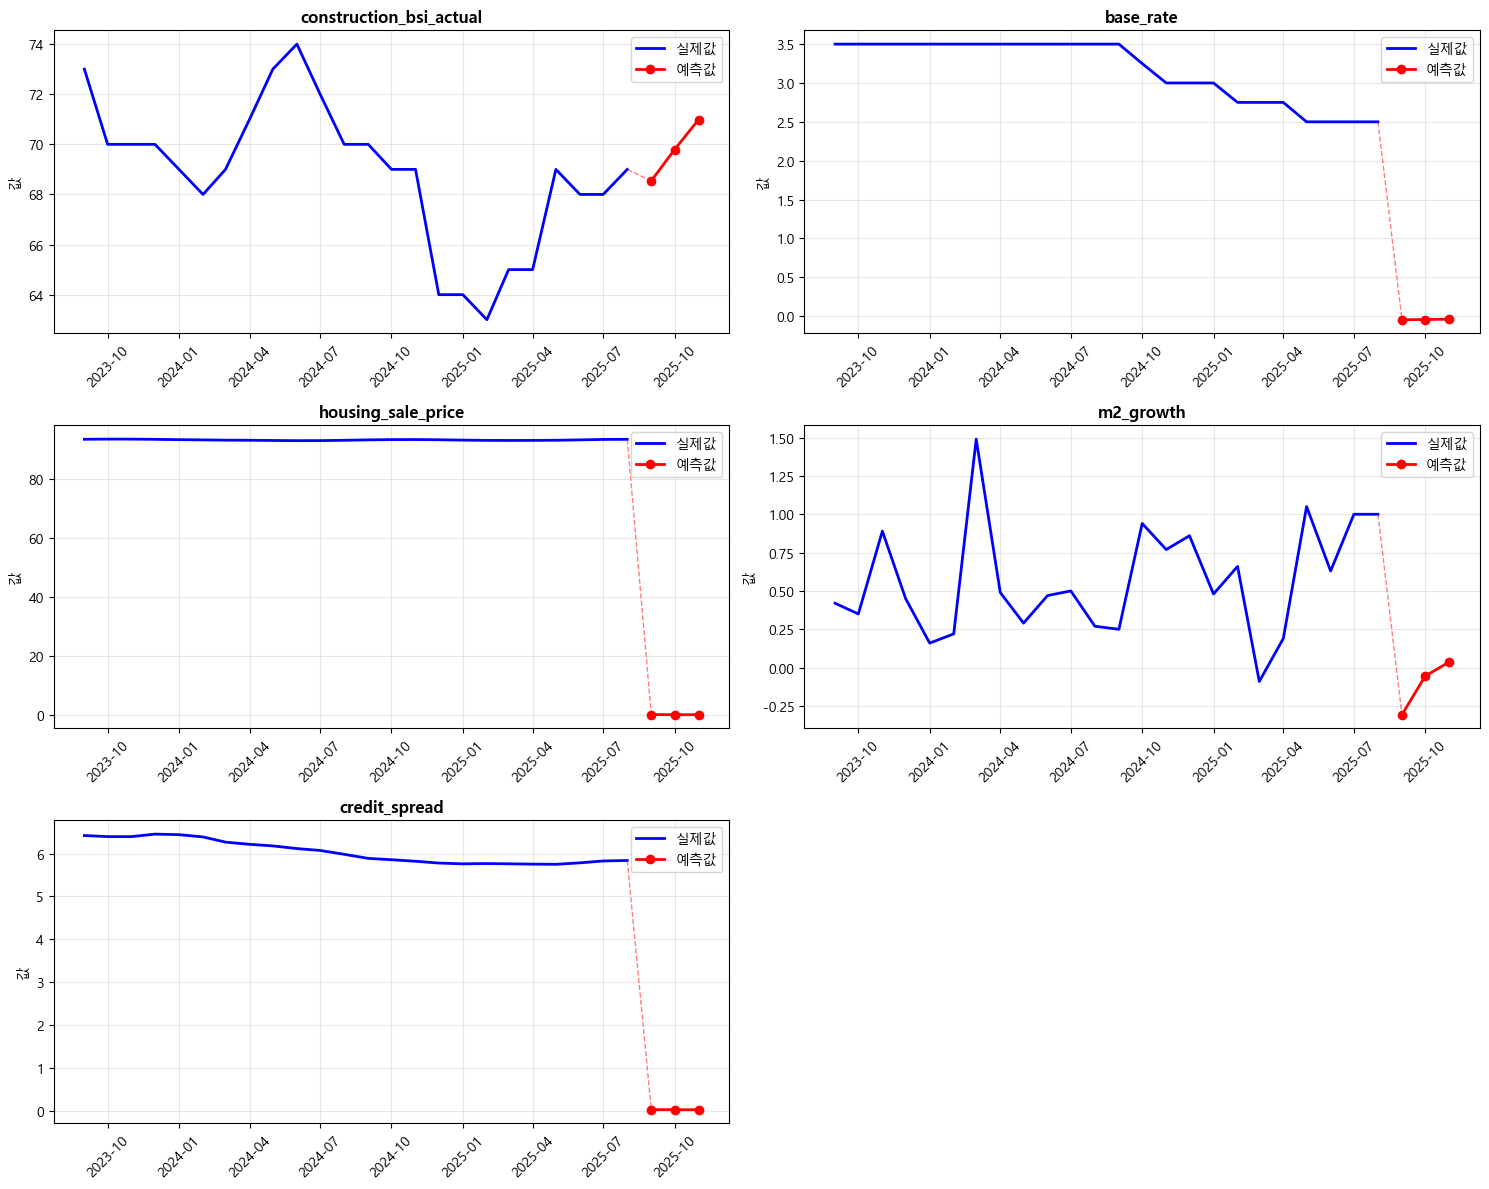

\n테스트 데이터 예측 정확도 시각화
----------------------------------------


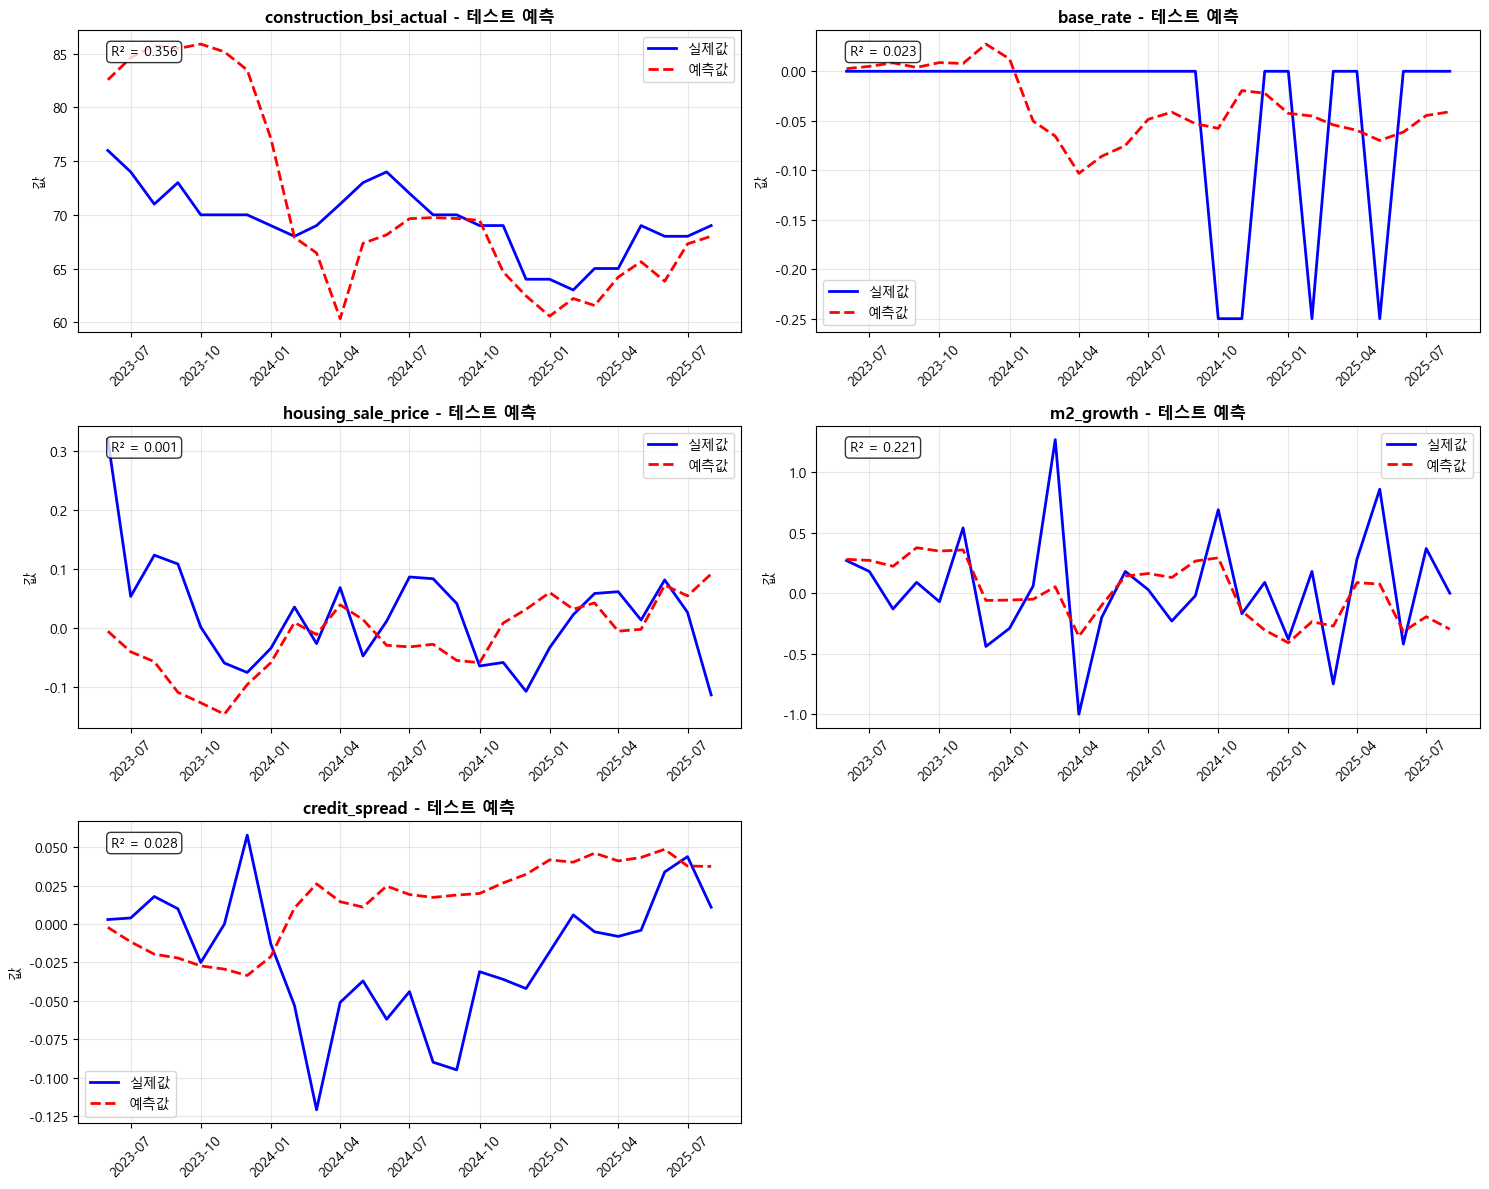

In [32]:
# 최적화된 모델 예측 결과 시각화
if 'optimized_forecast_df' in locals():
    print("최적화된 모델 예측 결과 시각화")
    print("=" * 40)
    
    # 시각화
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, var in enumerate(target_variables):
        ax = axes[i]
        
        # 과거 데이터 (최근 24개월)
        recent_data = df_target[var].iloc[-24:]
        ax.plot(recent_data.index, recent_data.values, 'b-', label='실제값', linewidth=2)
        
        # 미래 예측값
        future_values = optimized_forecast_df[var]
        ax.plot(future_values.index, future_values.values, 'r-o', 
                label='예측값', linewidth=2, markersize=6)
        
        # 연결선
        connection_x = [recent_data.index[-1], future_values.index[0]]
        connection_y = [recent_data.values[-1], future_values.values[0]]
        ax.plot(connection_x, connection_y, 'r--', alpha=0.5, linewidth=1)
        
        ax.set_title(f'{var}', fontsize=12, fontweight='bold')
        ax.set_ylabel('값')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # 빈 subplot 제거
    if len(target_variables) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    # 테스트 데이터 vs 예측값 비교
    if 'final_test_pred_original' in locals():
        print("\\n테스트 데이터 예측 정확도 시각화")
        print("-" * 40)
        
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        # 테스트 기간 인덱스 생성
        test_start_idx = len(df_stationary) - len(y_test)
        test_dates = df_stationary.index[test_start_idx:]
        
        for i, var in enumerate(target_variables):
            ax = axes[i]
            
            actual = final_test_actual_original[:, i]
            predicted = final_test_pred_original[:, i]
            
            ax.plot(test_dates, actual, 'b-', label='실제값', linewidth=2)
            ax.plot(test_dates, predicted, 'r--', label='예측값', linewidth=2)
            
            ax.set_title(f'{var} - 테스트 예측', fontsize=12, fontweight='bold')
            ax.set_ylabel('값')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # R² 계산 및 표시
            correlation = np.corrcoef(actual, predicted)[0, 1]
            r_squared = correlation ** 2
            ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 빈 subplot 제거
        if len(target_variables) < len(axes):
            fig.delaxes(axes[-1])
        
        plt.tight_layout()
        plt.show()
    
else:
    print("예측 결과가 없습니다. 이전 셀을 먼저 실행해주세요.")

In [33]:
# 최적화된 모델 분기별 예측 집계
if 'optimized_forecast_df' in locals():
    print("최적화된 모델 분기별 예측 집계")
    print("=" * 40)
    
    # 분기 할당 함수
    def assign_quarter(date):
        month = date.month
        if month in [1, 2, 3]:
            return "Q1"
        elif month in [4, 5, 6]:
            return "Q2"
        elif month in [7, 8, 9]:
            return "Q3"
        else:
            return "Q4"
    
    # 현재 날짜와 예측 날짜의 분기 확인
    current_date = df_target.index[-1]
    print(f"현재 날짜: {current_date.strftime('%Y-%m')} ({assign_quarter(current_date)})")
    
    # 예측 3개월의 분기 확인 및 그룹화
    quarterly_groups = {}
    for i, date in enumerate(optimized_forecast_df.index):
        quarter = assign_quarter(date)
        quarter_key = f"{date.year}_{quarter}"
        
        if quarter_key not in quarterly_groups:
            quarterly_groups[quarter_key] = []
        
        quarterly_groups[quarter_key].append(i)
        print(f"예측 {i+1}개월: {date.strftime('%Y-%m')} → {quarter_key}")
    
    # 분기별 평균 계산
    quarterly_forecast = {}
    print(f"\\n분기별 평균 계산:")
    print("-" * 30)
    
    for quarter_key, month_indices in quarterly_groups.items():
        quarter_data = optimized_forecast_df.iloc[month_indices]
        quarterly_avg = quarter_data.mean()
        quarterly_forecast[quarter_key] = quarterly_avg
        
        print(f"[{quarter_key}] ({len(month_indices)}개월 평균):")
        for var in target_variables:
            print(f"  {var}: {quarterly_avg[var]:.4f}")
        print()
    
    # 분기별 결과 DataFrame 생성
    if quarterly_forecast:
        quarterly_df = pd.DataFrame(quarterly_forecast).T
        quarterly_df.index.name = 'Quarter'
        
        print("분기별 예측 요약:")
        print("-" * 30)
        print(quarterly_df.round(4))
        
        # 재무재표 계산용 데이터 정리
        print("\\n재무재표 계산용 분기별 데이터:")
        print("-" * 30)
        
        for quarter, data in quarterly_forecast.items():
            print(f"{quarter}:")
            print(f"  건설업BSI실적: {data['construction_bsi_actual']:.2f}")
            print(f"  기준금리: {data['base_rate']:.2f}%")
            print(f"  주택매매가격지수: {data['housing_sale_price']:.1f}")
            print(f"  M2증가율: {data['m2_growth']:.2f}%")
            print(f"  신용스프레드: {data['credit_spread']:.0f}bp")
            print()
        
        print("이 데이터를 DART 분기별 재무데이터와 결합하여 사용하세요.")
    
else:
    print("예측 결과가 없습니다. 이전 셀을 먼저 실행해주세요.")

최적화된 모델 분기별 예측 집계
현재 날짜: 2025-08 (Q3)
예측 1개월: 2025-09 → 2025_Q3
예측 2개월: 2025-10 → 2025_Q4
예측 3개월: 2025-11 → 2025_Q4
\n분기별 평균 계산:
------------------------------
[2025_Q3] (1개월 평균):
  construction_bsi_actual: 68.5432
  base_rate: -0.0458
  housing_sale_price: 0.0804
  m2_growth: -0.3070
  credit_spread: 0.0290

[2025_Q4] (2개월 평균):
  construction_bsi_actual: 70.3890
  base_rate: -0.0412
  housing_sale_price: 0.0375
  m2_growth: -0.0088
  credit_spread: 0.0273

분기별 예측 요약:
------------------------------
         construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
Quarter                                                                      
2025_Q3                68.543198    -0.0458              0.0804    -0.3070   
2025_Q4                70.389000    -0.0412              0.0375    -0.0088   

         credit_spread  
Quarter                 
2025_Q3         0.0290  
2025_Q4         0.0273  
\n재무재표 계산용 분기별 데이터:
------------------------------
2025_Q3:
  건설업BSI실적: 68.54
  기준금